## Netflix Movie Recommendation System

### Problem Description

Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.

### Objectives:

Predict the rating that a user would give to a movie that he ahs not yet rated.

Minimize the difference between predicted and actual rating (RMSE and MAPE) 

### Data Overview

<p> Data files : 
<ul> 
<li> combined_data_1.txt </li>
<li> combined_data_2.txt </li>
<li> combined_data_3.txt </li>
<li> combined_data_4.txt </li>
<li> movie_titles.csv </li>
</ul>

The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD.

### Type of Machine Learning Problem

For a given movie and user we need to predict the rating would be given by him/her to the movie.

The given problem is a Recommendation problem 

It can also seen as a Regression problem 

### Performance metric

Mean Absolute Percentage Error

Root Mean Square Error

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

### EDA

### Text Preprocessing

### Merging all text files into a single CSV file

In [2]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We are reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000419


### Sorting the Dataframe by Date

In [3]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [4]:
df.head(3)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11


### Analysis of the 'Ratings' column

In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Checking for NaN values

In [6]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


### Removing the duplicate rows

In [7]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


### Basic Statistics (#Ratings, #Users, and #Movies)

In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


### Spliting data into Train and Test(80:20) ( Returning train and test Pandas Dataframes)

In [9]:
from sklearn.model_selection import train_test_split
start = datetime.now()

if not os.path.isfile('train.csv'or'test.csv'):
    train, test = train_test_split(df, test_size=0.2,shuffle=False)
    train.to_csv('train.csv',index=False)
    test.to_csv('test.csv',index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")
print('Time taken :', datetime.now() - start)

Time taken : 0:01:18.217323


### Basic Statistics in Train data (#Ratings, #Users, and #Movies)

In [10]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


### Exploratory Data Analysis on Train data

In [11]:
def y_labels(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

### Exploratory Data Analysis

In [149]:
user_dist = df.groupby('user')['rating'].count()[:1000]

In [151]:
movie_dist = df.groupby('movie')['rating'].count()[:1000]

In [74]:
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

### Histogram plot of the distribution of count of ratings given for a movie for first 1000 movies

In [158]:
trace = go.Histogram(x=movie_dist.values,name = 'Ratings',xbins = dict(start = 0,end = 7000,size = 100))

layout = go.Layout(title = 'Distribution Of Ratings Per Movie',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

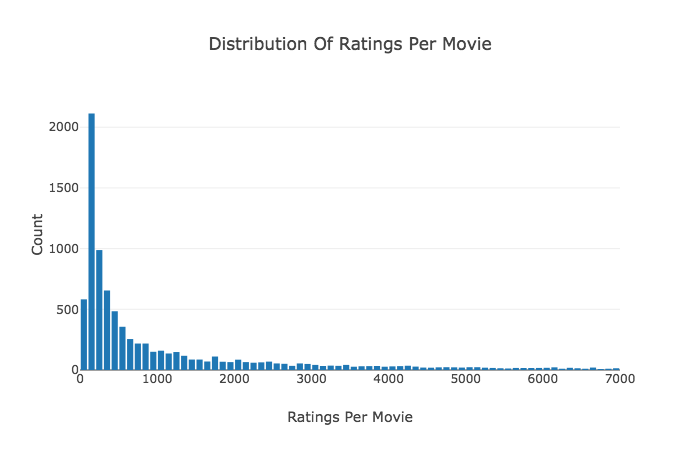

In [157]:
from IPython.display import Image
Image(filename='newplot3.png')

### Histogram plot of the distribution of ratings given per movie by first 1000 users

In [159]:
trace = go.Histogram(x = user_dist.values,name = 'Ratings',xbins = dict(start = 0,end = 300,size = 5))

layout = go.Layout(title = 'Distribution Of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

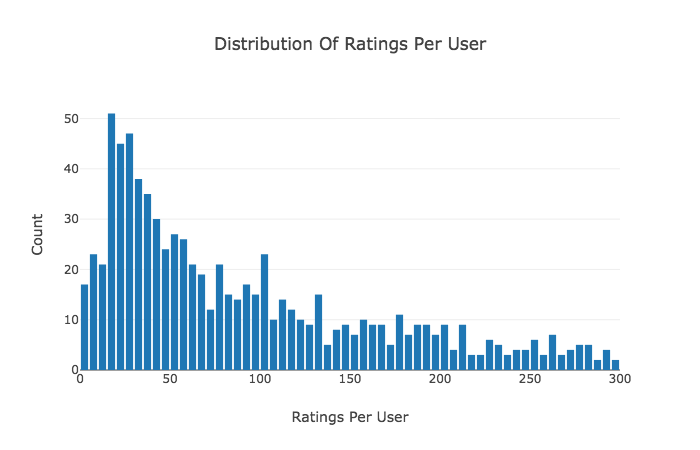

In [156]:
Image(filename='newplot2.png')

### Percentage decrease in the no. of users who have rated atleast 50 movies

In [123]:
min_users = df['user'].value_counts()>50
usr_count = min_users[min_users].index

In [125]:
usr_50 = len(np.unique(usr_count))
usr_all = len(np.unique(df.user))

In [127]:
user_decrease = ((usr_all - usr_50)/usr_all)*100
print('Percentage decrease in the total no. of users who have rated atleast 50 movies is {}%'.format(user_decrease))

Percentage decrease in the total no. of users who have rated atleast 50 movies is 32.42848128549384%


### Percentage decrease in the no. of movies which have  been rated atleast 200 times

In [131]:
min_movie = df['movie'].value_counts()>200
movie_count = min_movie[min_movie].index

In [132]:
movie_50 = len(np.unique(movie_count))
movie_all = len(np.unique(df.movie))

In [134]:
movie_decrease = ((movie_all - movie_50)/movie_all)*100
print('Percentage decrease in the total no. of movies that have been rated atleast 200 times is {}%'.format(movie_decrease))

Percentage decrease in the total no. of movies that have been rated atleast 200 times is 26.409679234665166%


In [135]:
movie_df = pd.read_csv("movie_titles.csv")
movie_df.head(3)

,ID,Year,Movie
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character


In [146]:
movie_cnt_by_year = movie_df['Year'].value_counts().sort_values(ascending=True)

### Scatter plot of the Distribution Of Movies based on release year

In [160]:
trace = go.Scatter(x = movie_cnt_by_year.index,y=movie_cnt_by_year.values)

layout = go.Layout(title = 'Distribution Of Movies based on release year',
                   xaxis = dict(title = 'Ratings of Movies Based on Release Year'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

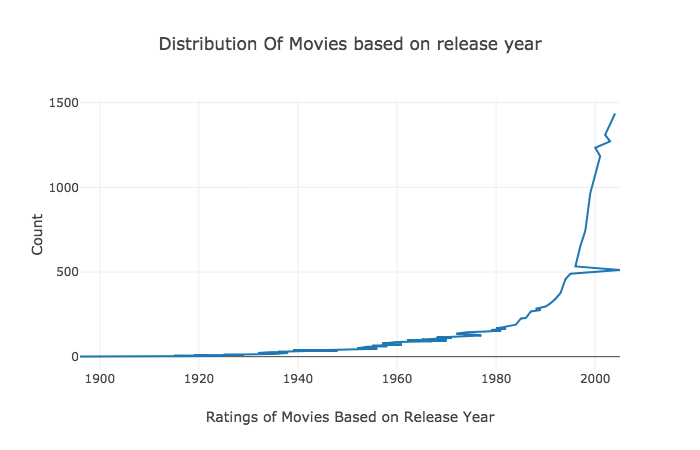

In [155]:
Image(filename='newplot.png')

### Distribution of ratings

<IPython.core.display.Javascript object>


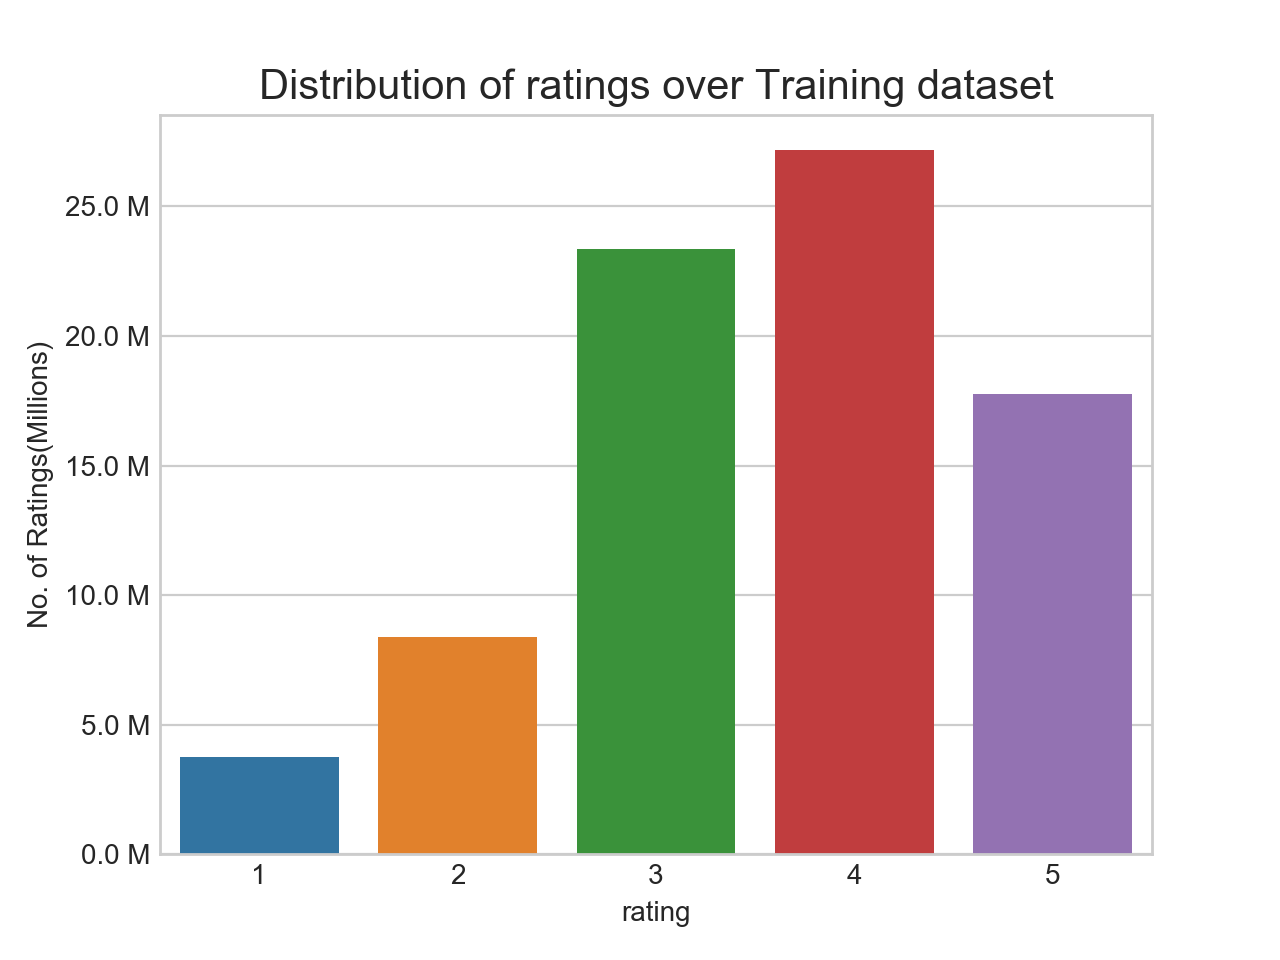

In [16]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([y_labels(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')
plt.show()

### Add new column (week day) to the data set for analysis.

In [17]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'
train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.tail(3)

,movie,user,rating,date,day_of_week
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


### Number of Ratings per month

<IPython.core.display.Javascript object>


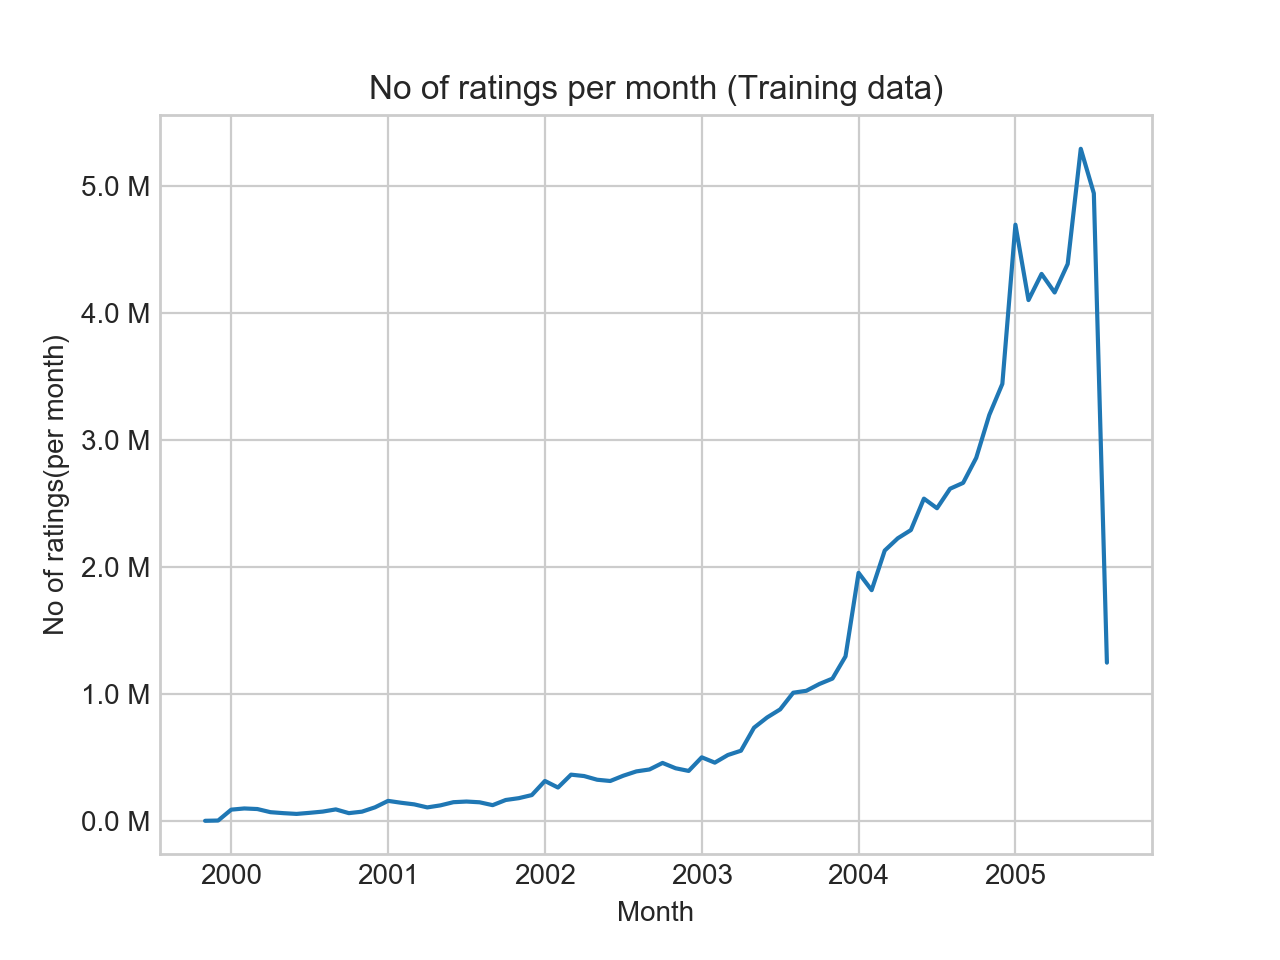

In [18]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([y_labels(item, 'M') for item in ax.get_yticks()])
plt.show()

In [19]:
train_df.resample('m', on='date')['rating'].count().head() ## Shows the month wise count of the ratings given.

date
1999-11-30       28
1999-12-31     2150
2000-01-31    87914
2000-02-29    97318
2000-03-31    92697
Freq: M, Name: rating, dtype: int64

### Analysis on the Ratings given by user

In [20]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

### PDF & CDF plots of the no. of ratings given per user

<IPython.core.display.Javascript object>


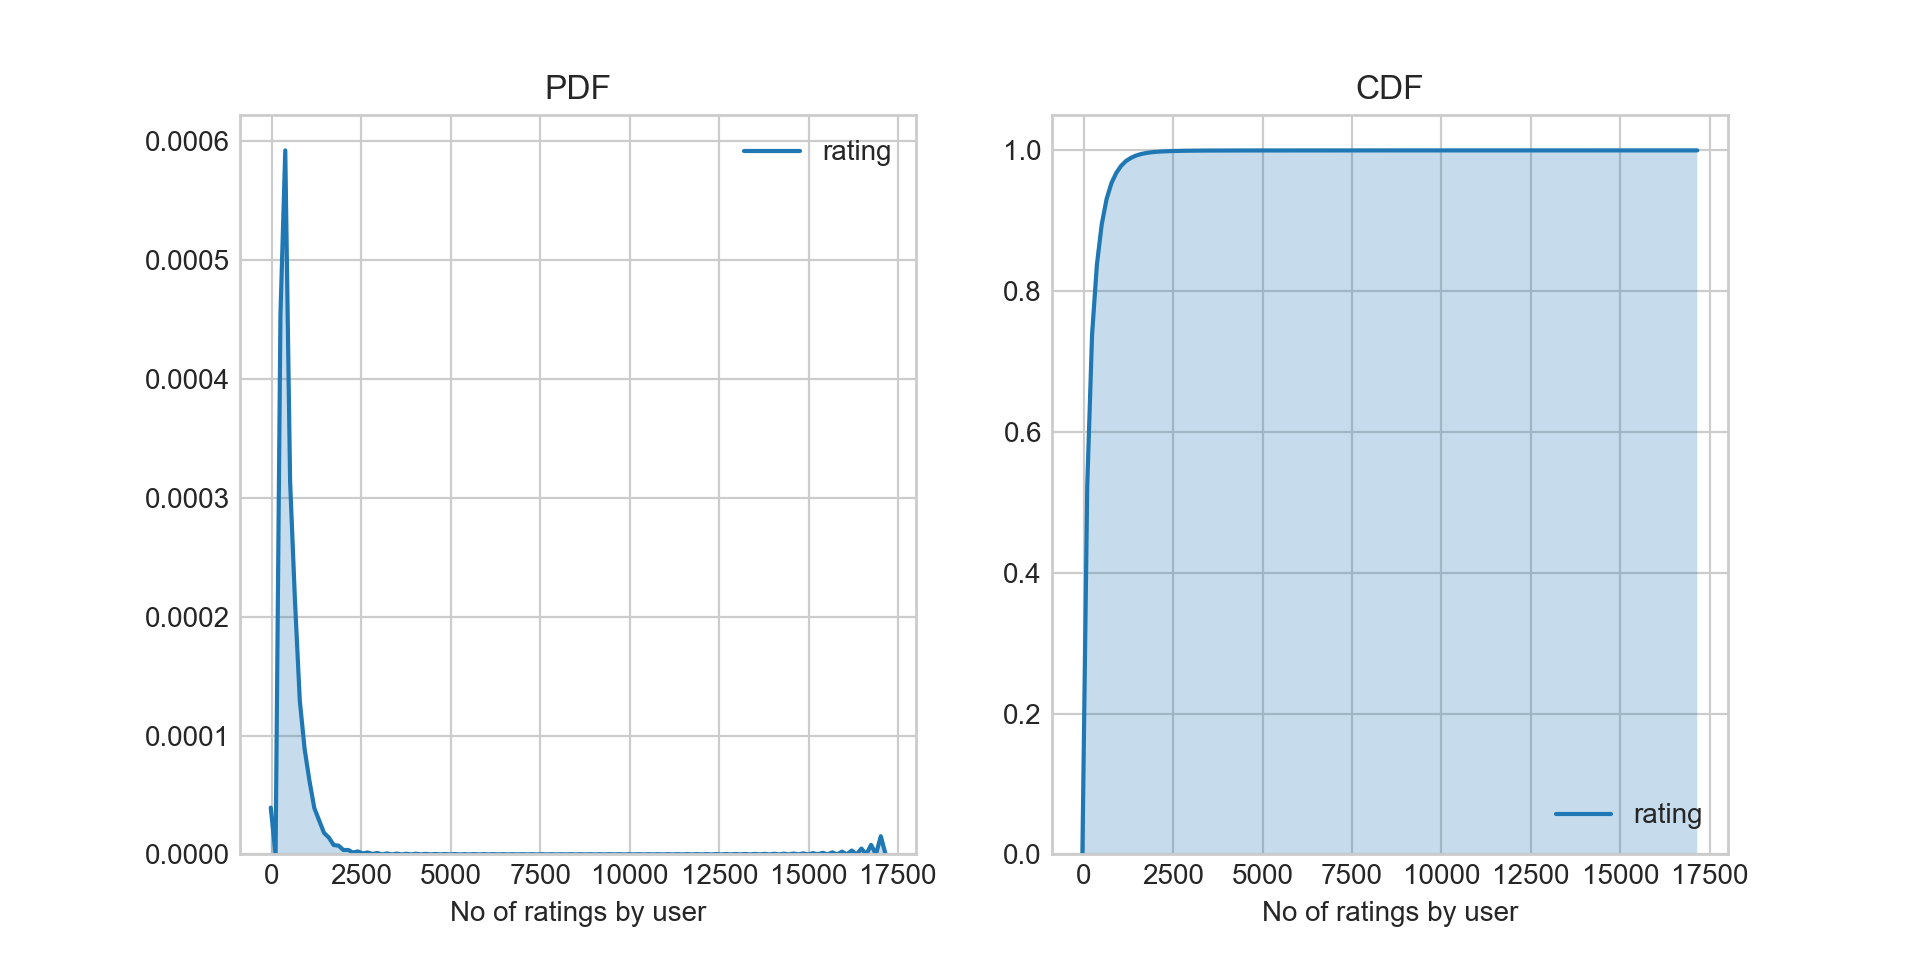

In [21]:
import warnings
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')
plt.show()

In [22]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

It can be seen that on an average a user rates around 200 movies

### Quantile plots of the no. of ratings per user

In [23]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


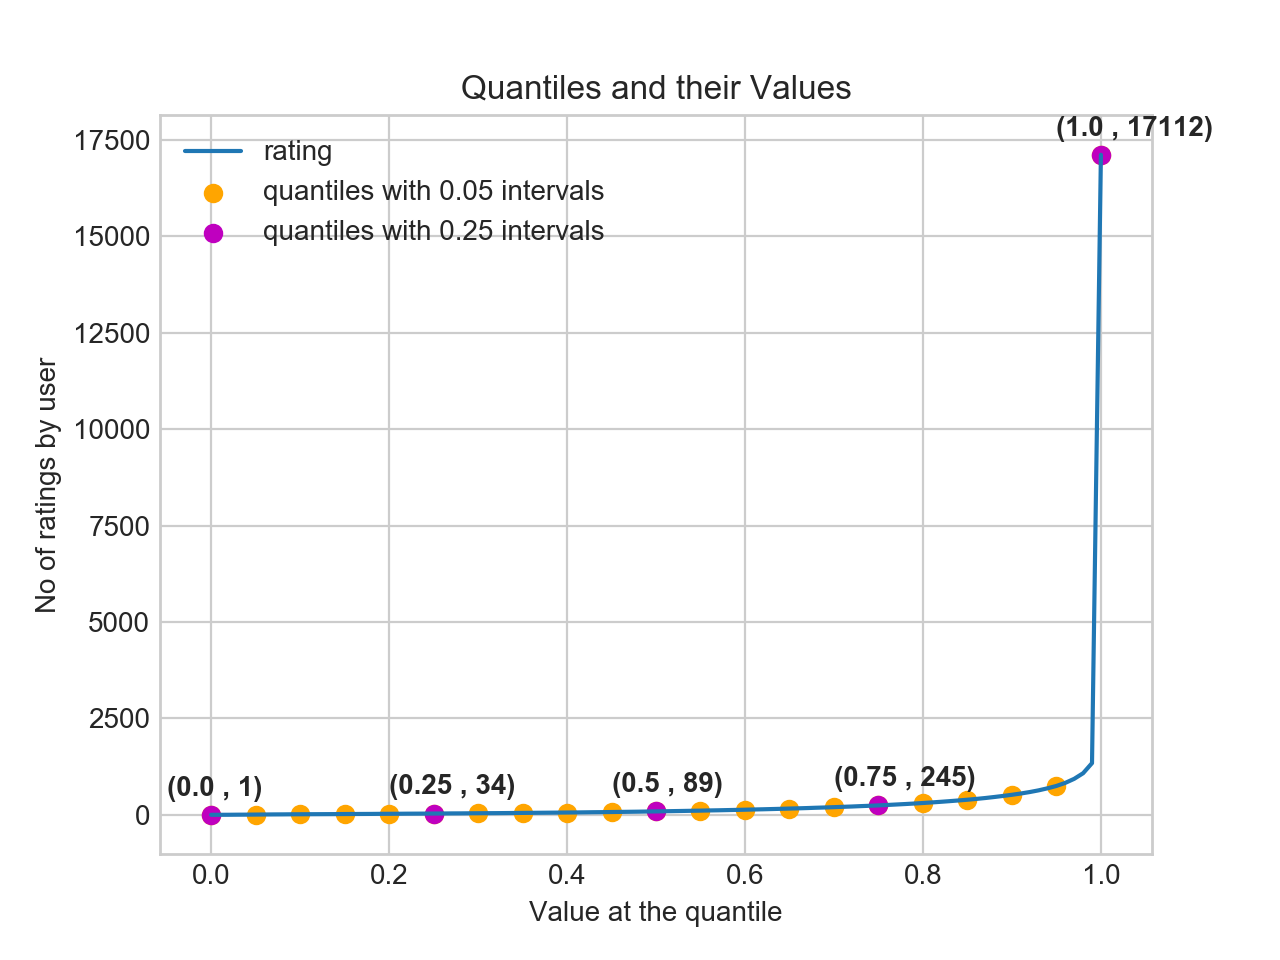

In [24]:
plt.title("Quantiles and their Values")
quantiles.plot()

# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")

plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.show()

In [25]:
quantiles[::25]

0.00        1
0.25       34
0.50       89
0.75      245
1.00    17112
Name: rating, dtype: int64

In [26]:
print('No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)))

No of ratings at last 5 percentile : 20305



### Analysis of ratings of a movie given by a user

<IPython.core.display.Javascript object>


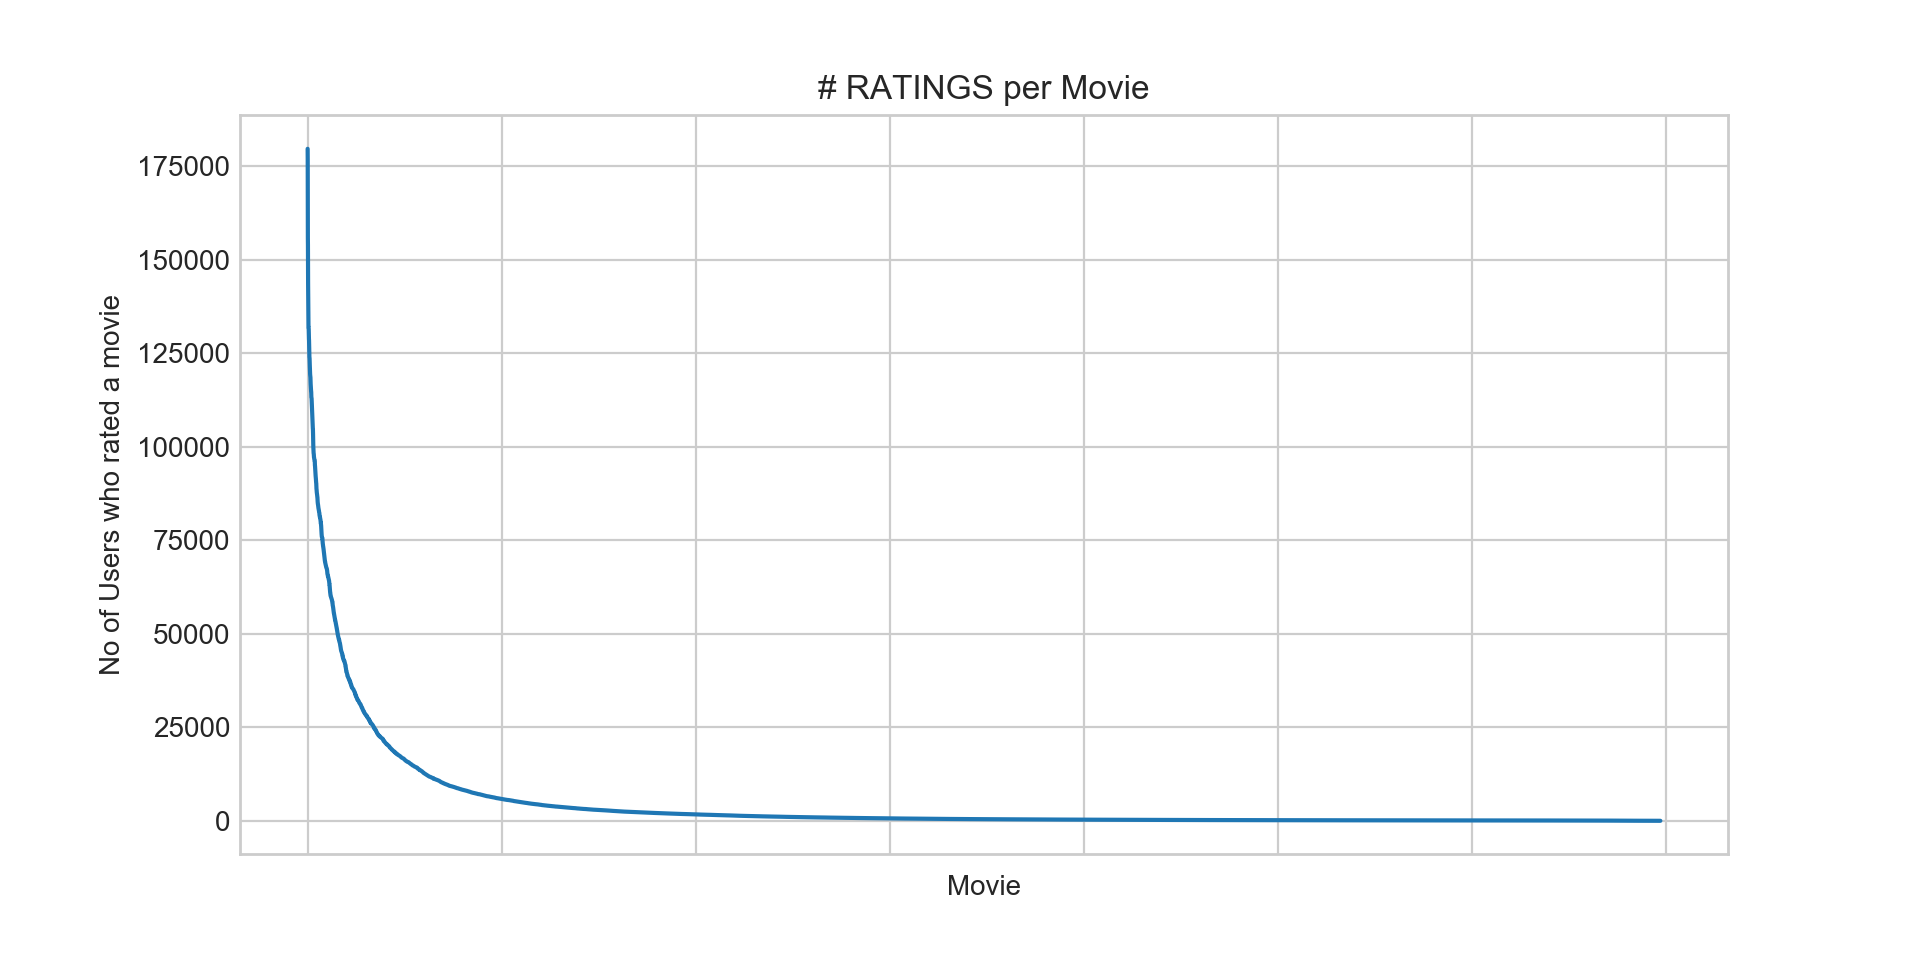

In [27]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

It can be seen that there are more number of users(about 1,25,000 and above) who have rated for a single movie with about 90% of the movies getting an average number of 100 ratings.

### Number of ratings on each day of the week

<IPython.core.display.Javascript object>


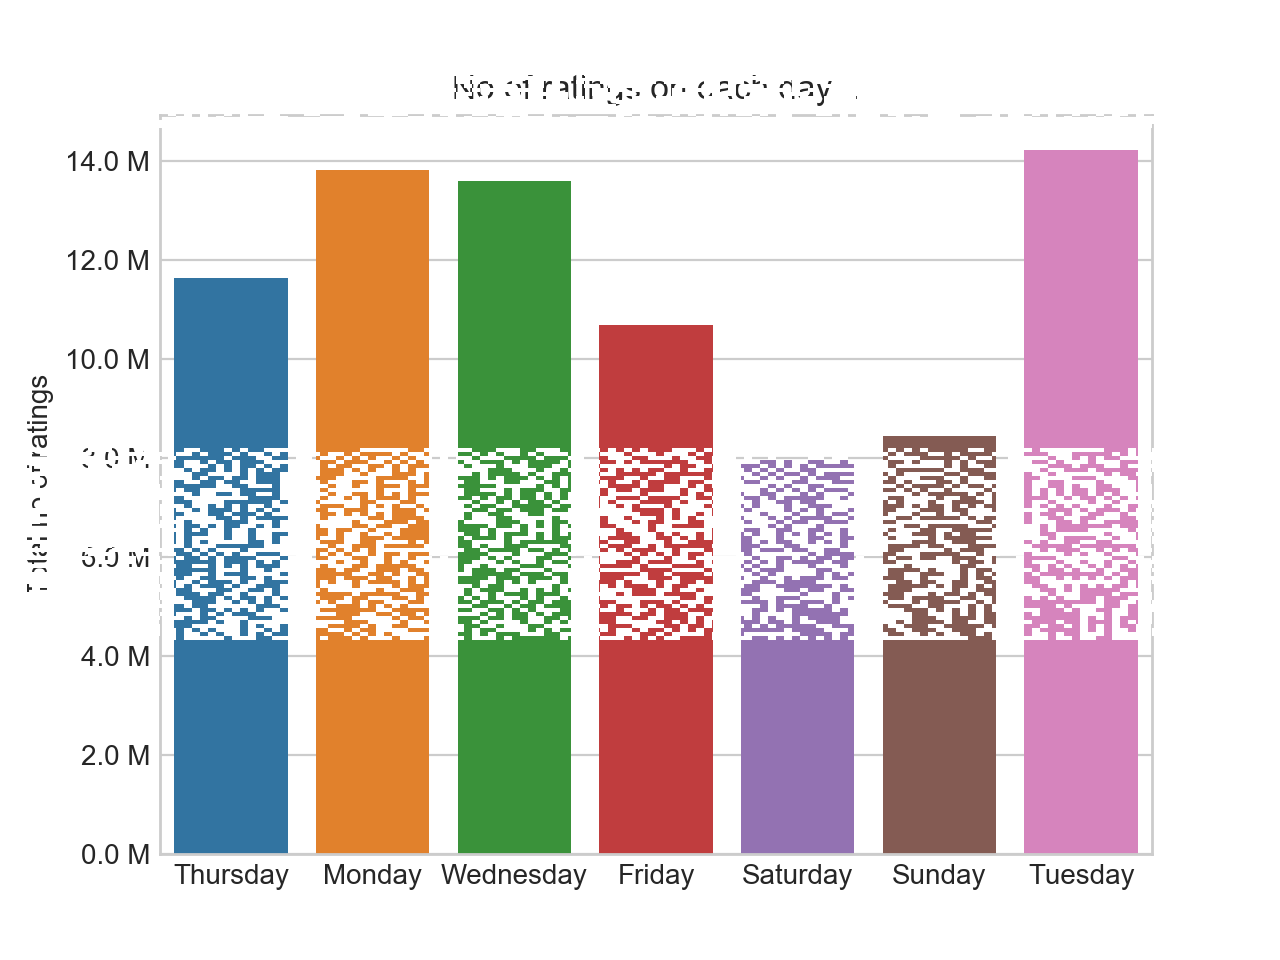

In [28]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([y_labels(item, 'M') for item in ax.get_yticks()])
plt.show()

It can be observed that there are more number of ratings given on weekdays than weekends

<IPython.core.display.Javascript object>


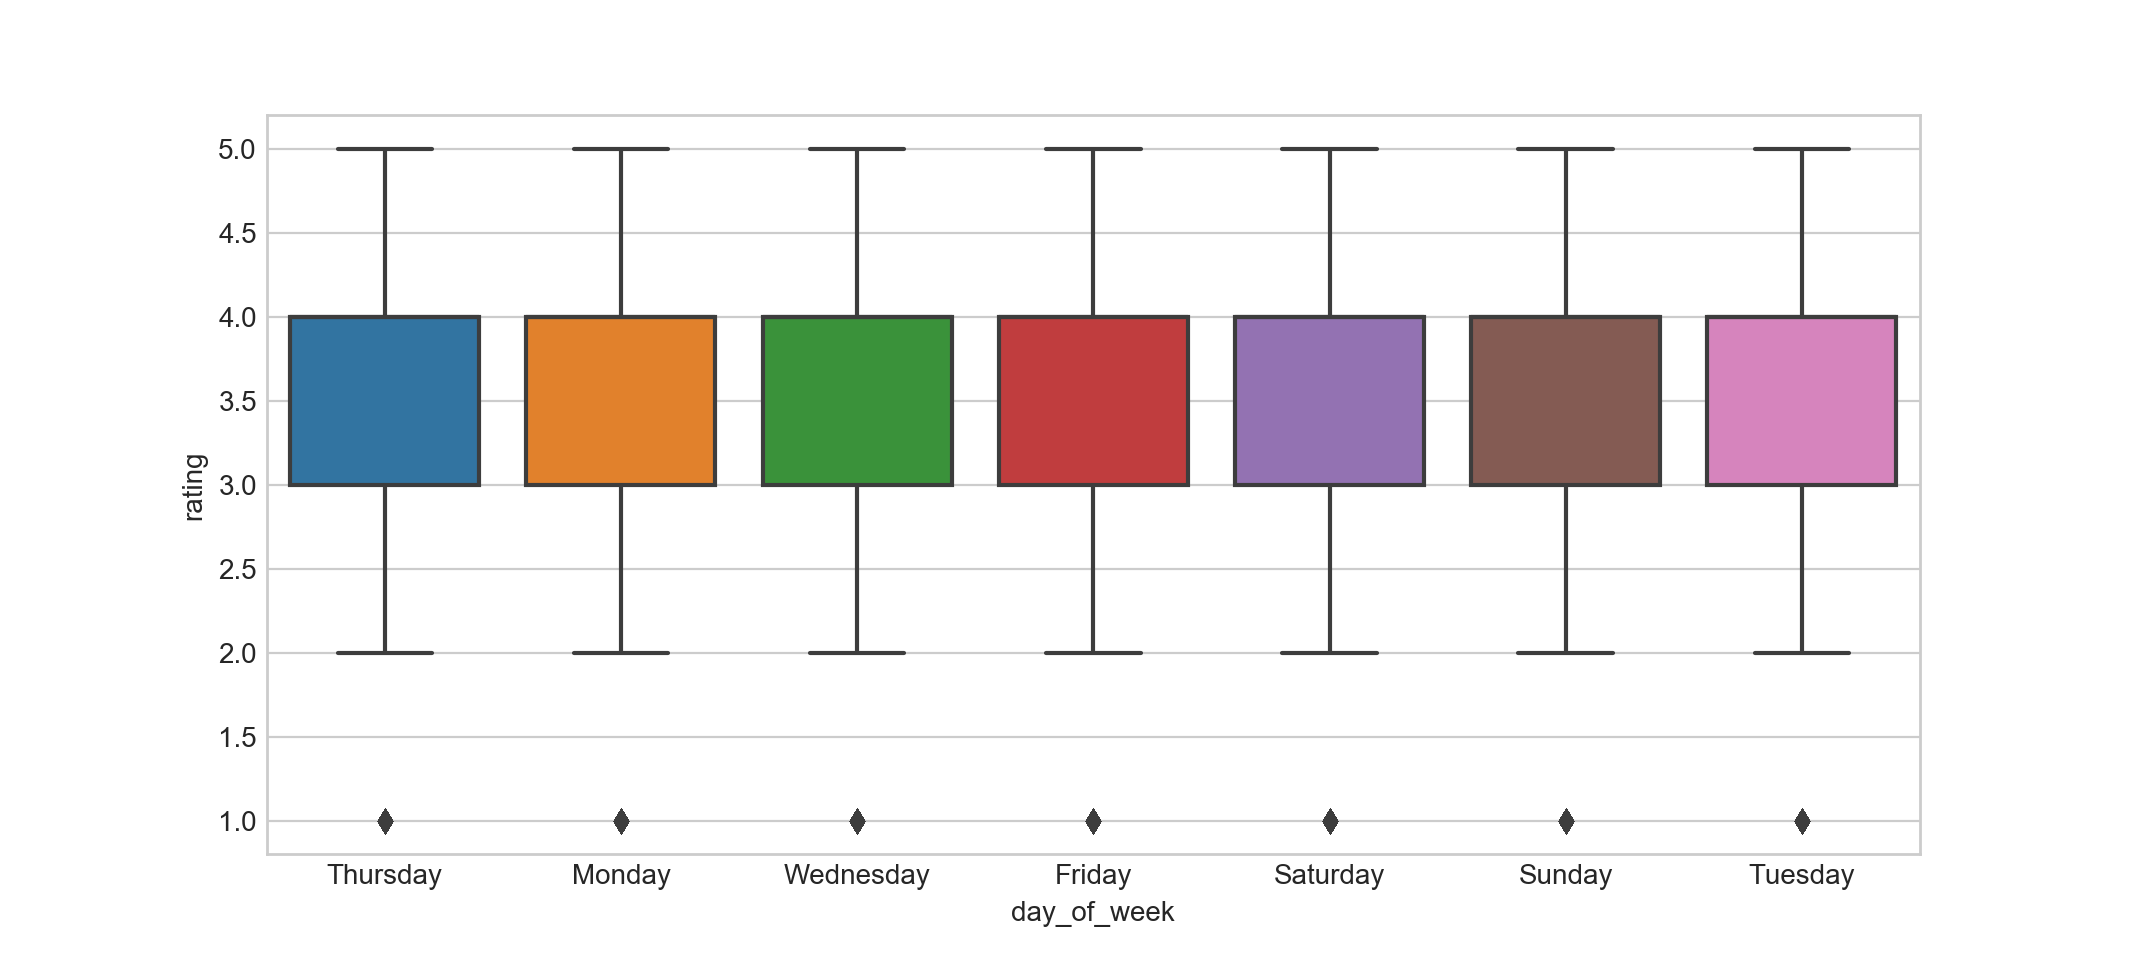

0:00:17.662795


In [30]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [31]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




It can be seen that the day of the week is not ideal for feature selection

### Creating sparse matrix from data frame

### Creating sparse matrix from train data frame

In [32]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df["rating"].values, (train_df["user"].values,
                                               train_df["movie"].values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:04.950919


### Sparsity of the train sparse matrix

In [34]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


### Creating sparse matrix from test data frame

In [35]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.980968


### Sparsity of the test sparse matrix

In [36]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [37]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

### Global average of all movie ratings

In [38]:
train_averages = dict()

# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

### Average rating per user

In [39]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('Average rating of user 10 :',train_averages['user'][10])

Average rating of user 10 : 3.3781094527363185


### Average rating per movie

In [40]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('Average rating of movie 15 :',train_averages['movie'][15])

Average rating of movie 15 : 3.3038461538461537


### PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)

<IPython.core.display.Javascript object>


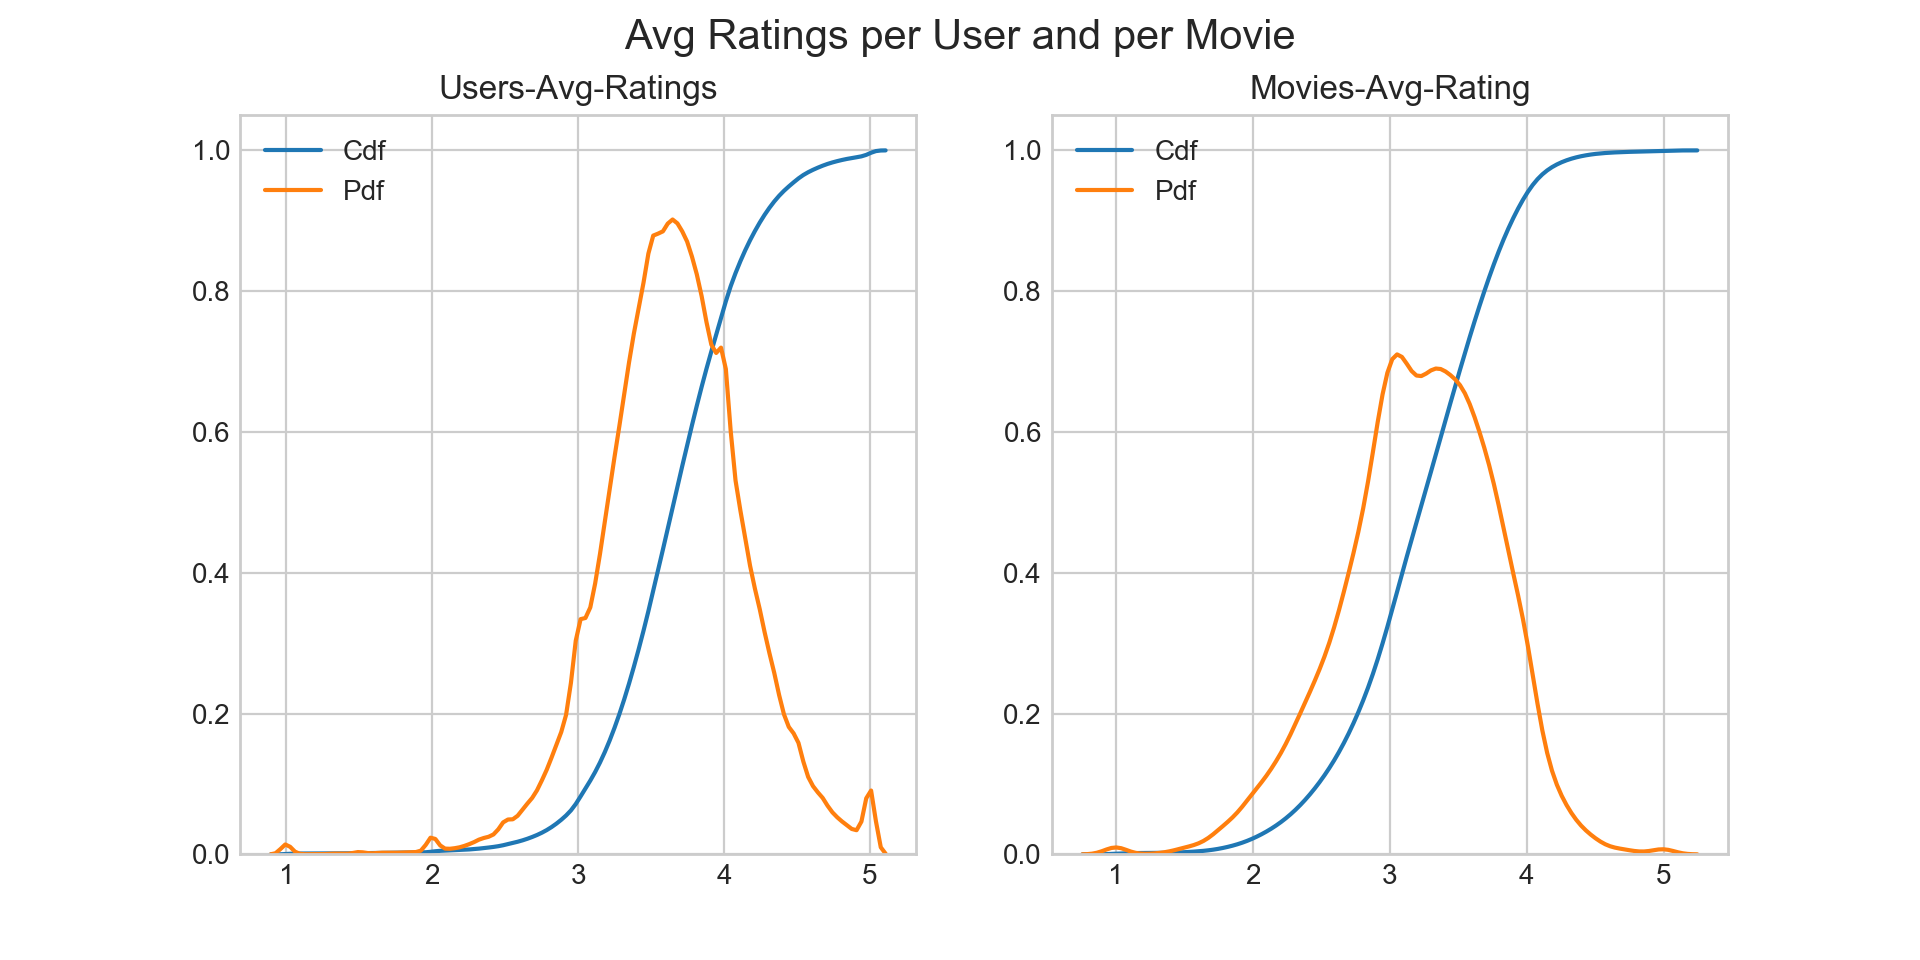

0:00:18.358980


In [41]:
start = datetime.now()

# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

### Cold Start problem

### Cold Start problem with Users

In [42]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('Total number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))

Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


### Cold Start problem with Movies

In [43]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('Total number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))

Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


### Computing Similarity matrices

### Computing User-User Similarity matrix

### Trying with all dimensions (17k dimensions per user)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken    

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:02:06.599244  ]
computing done for 40 users [  time elapsed : 0:04:04.310367  ]
computing done for 60 users [  time elapsed : 0:06:06.202286  ]
computing done for 80 users [  time elapsed : 0:08:14.510652  ]
computing done for 100 users [  time elapsed : 0:10:22.184957  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


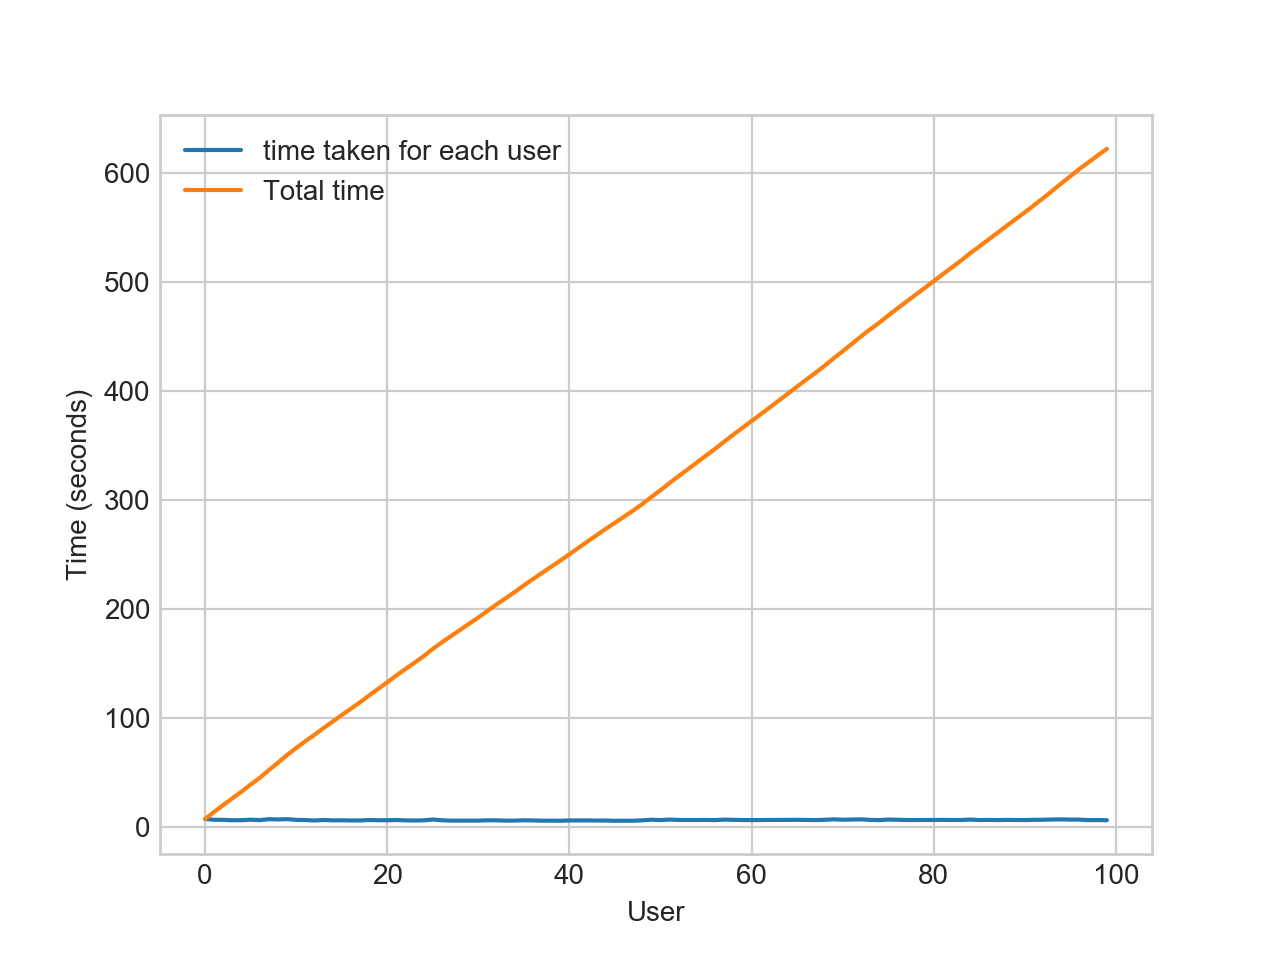

----------------------------------------------------------------------------------------------------
Time taken : 0:10:34.835424


In [75]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

The above method of calculating user-user similarity matrix takes a lot of time for all users. Instead,we will try to reduce the dimensions using SVD, so that it might speed up the process...

### Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)

In [76]:
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

netflix_svd = TruncatedSVD(n_components=200, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

0:07:05.988678


Here,

∑⟵  (netflix_svd.singular_values_ )

⋁𝑇⟵  (netflix_svd.components_)

⋃  is not returned. instead Projection_of_X onto the new vectorspace is returned.

It uses randomized svd internally, which returns All 3 of them seperately. Use that instead.

In [77]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

<IPython.core.display.Javascript object>


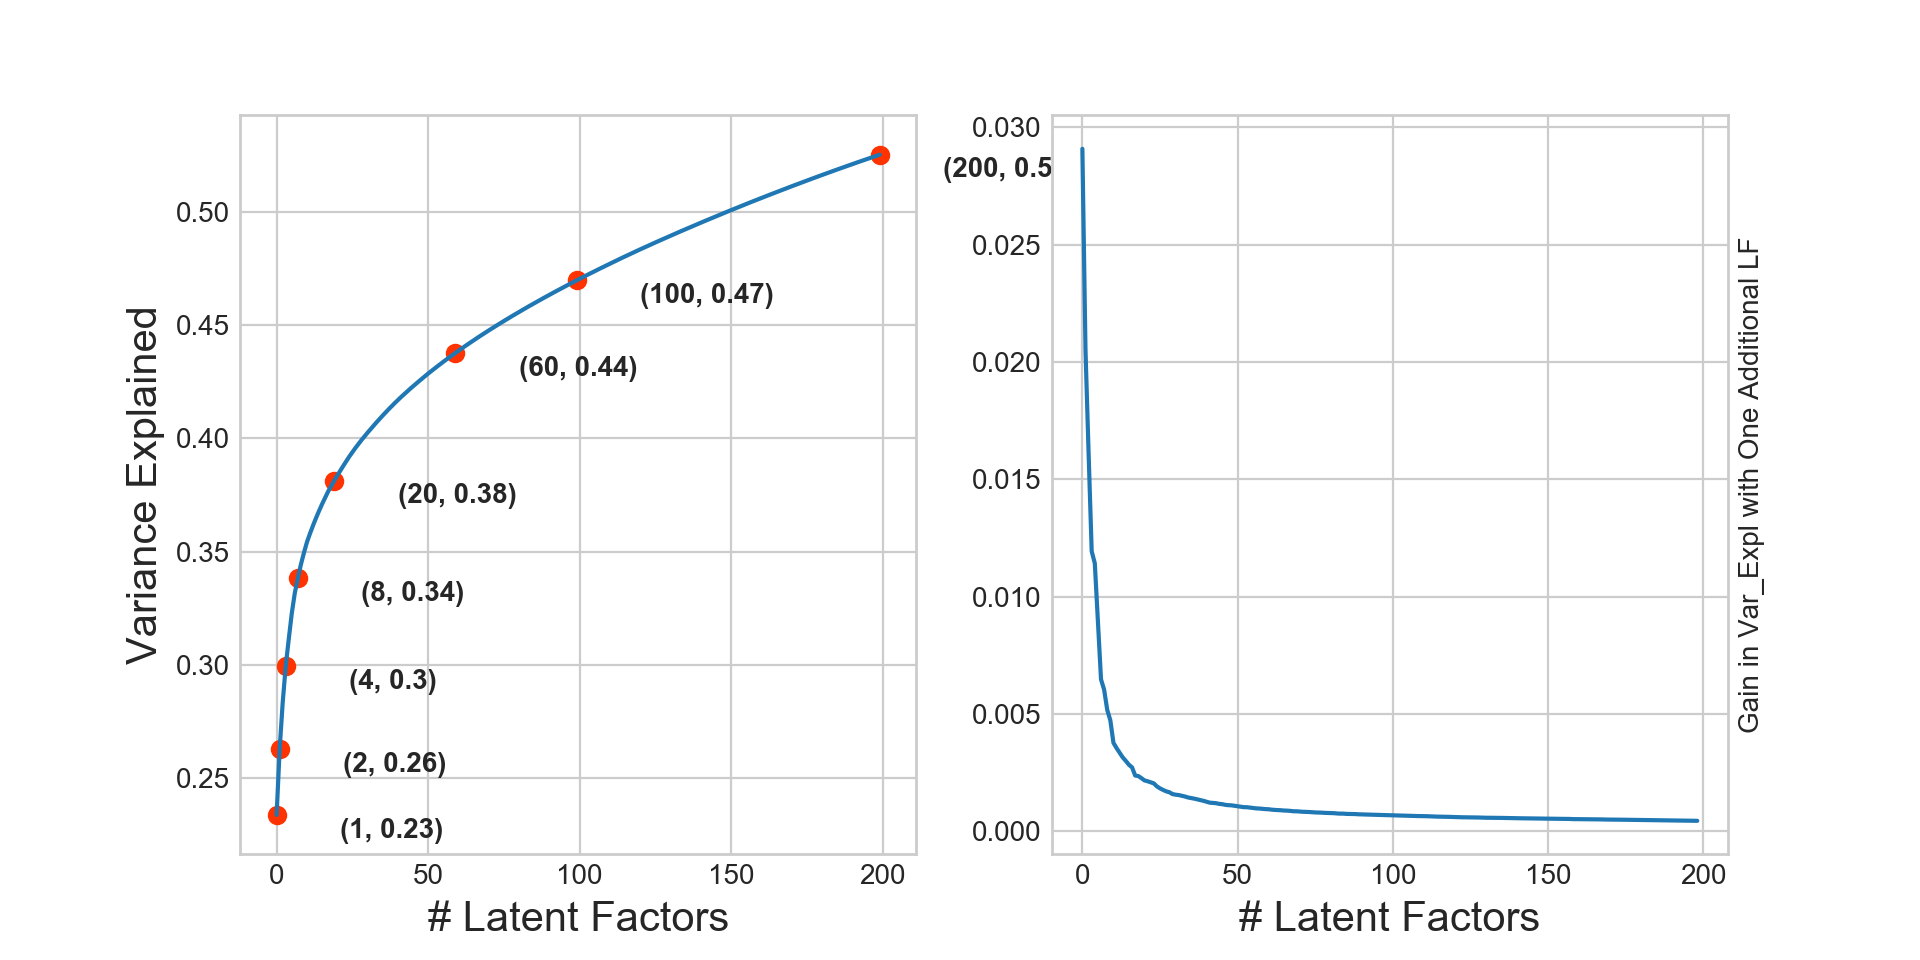

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Factors", fontsize=15)
ax1.plot(expl_var)

ind = [1, 2,4,8,20, 60, 100, 200]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Factors", fontsize=15)

plt.show()

In [82]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.3)
(8, 0.34)
(20, 0.38)
(60, 0.44)
(100, 0.47)
(200, 0.53)


### Projecting the U_M matrix into 200 Dimensional space

In [83]:
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:11.537798


In [84]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 200))

In [85]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [86]:
trunc_sparse_matrix.shape

(2649430, 200)

Computing top 50 similarities for each user..
computing done for 10 users [  time elapsed : 0:00:43.322329  ]
computing done for 20 users [  time elapsed : 0:01:25.720881  ]
computing done for 30 users [  time elapsed : 0:02:08.779994  ]
computing done for 40 users [  time elapsed : 0:02:50.988091  ]
computing done for 50 users [  time elapsed : 0:03:33.313835  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


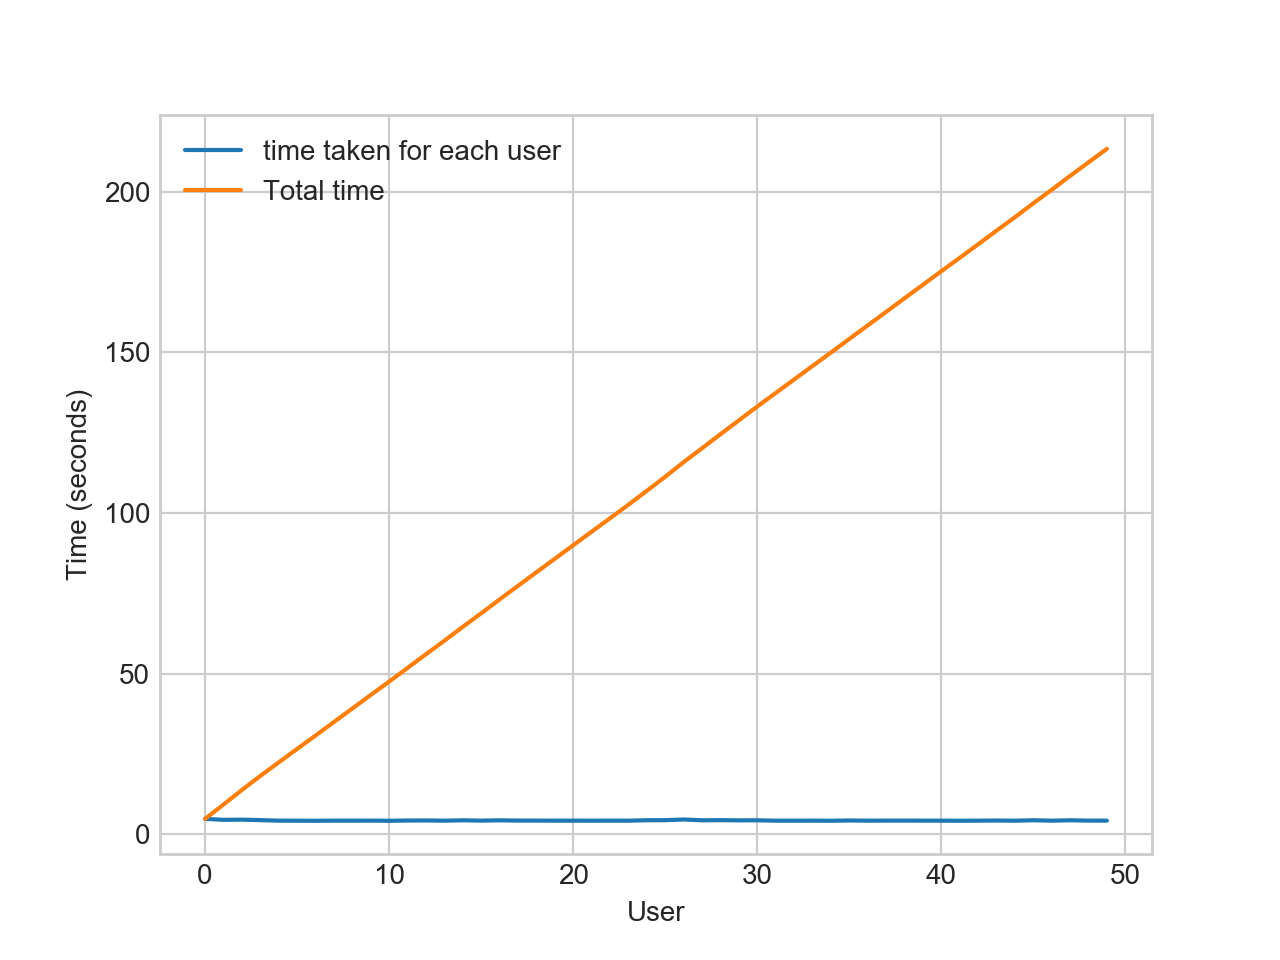

--------------------------------------------------
time: 0:03:47.008275


In [87]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

It takes around 12 seconds for computing similarity for a single user. The computation time is way higher than the previous method due to the operations done between sparse matrices in the previous method and operations done between dense matrices in this method.

An alternative way to compute user-user similarity matrices is to compute them at run time. We can use a dictionary to implement this. It can be implemented as shown below:

 - **key    :** _userid_ 
        - __value__: _Again a dictionary_
            - __key__  : _Similar User_
            - __value__: _Similarity Value_

### Computing Movie-Movie Similarity matrix

In [88]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix
0:07:50.545523


In [89]:
m_m_sim_sparse.shape

(17771, 17771)

In [90]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

### Getting the similar movie ids corresponding to a single movie

In [109]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:28.439513


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

### Finding most similar movies using similarity matrix

In [110]:
movie_titles = pd.read_csv("data_folder/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 5.03 ms
Type conversion took: 17.02 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [111]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similar to this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 270 Ratings from users.

We have 17284 movies which are similar to this  and we will get only top most..


In [112]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


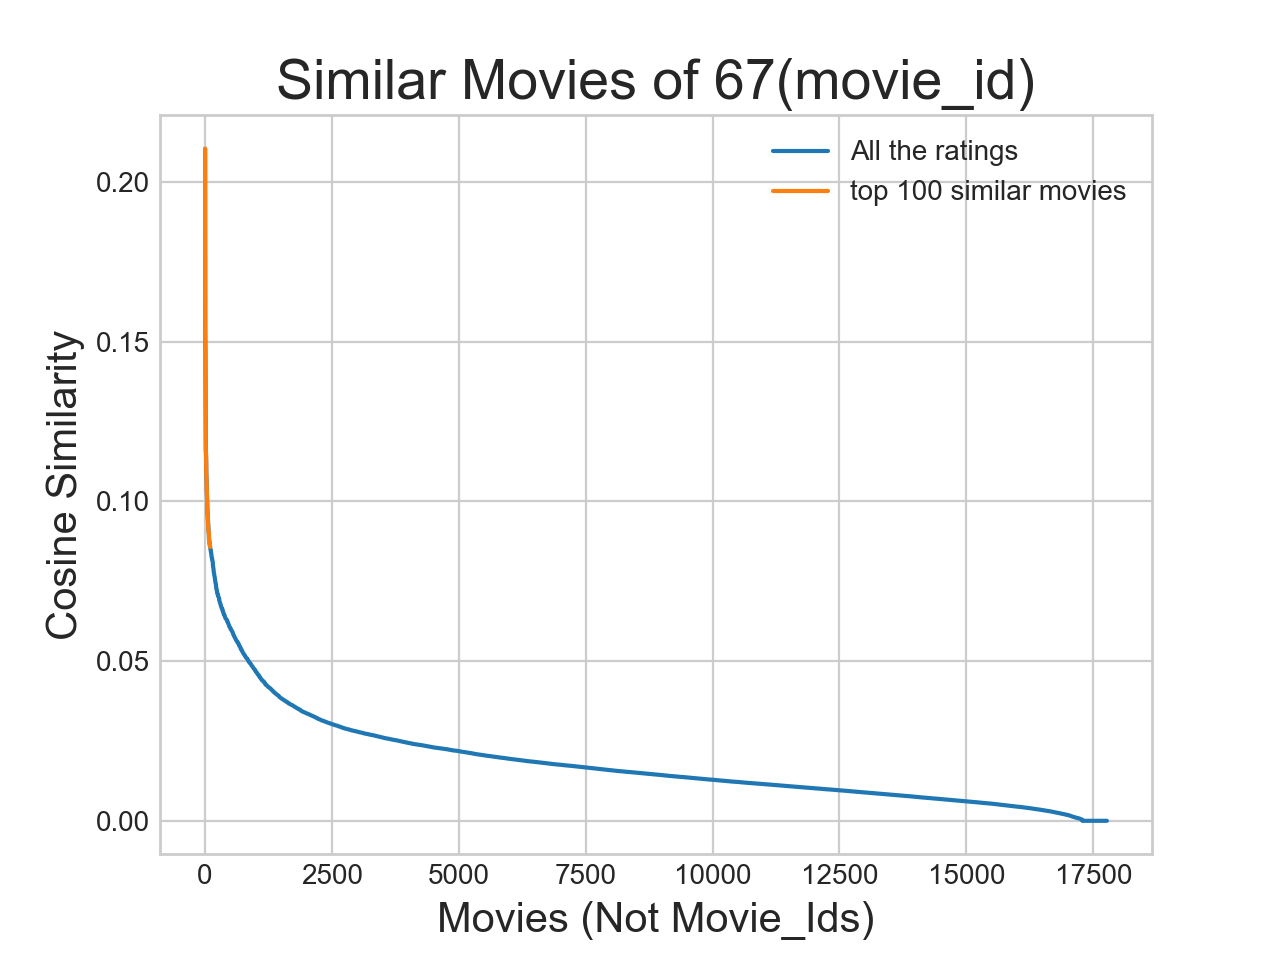

In [113]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [114]:
movie_titles.loc[sim_indices[:7]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella


### Machine Learning Models

In [45]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for further usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

In [46]:
start = datetime.now()
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 25k users and 3k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=3000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.067598


In [47]:
a1 = np.array([1,2,3])
a2 = np.array([True,False,True])
a1[a2]

array([1, 3])

### Build sample test data from the test data

In [48]:
start = datetime.now()

path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=20000, no_movies=2500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.035852


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [49]:
sample_train_averages = dict()

### Finding Global Average of all movie ratings

In [50]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5875813607223455}

### Finding Average rating per User

In [51]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.923076923076923


### Finding Average rating per Movie

In [52]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('Average rating of movie 15153 :',sample_train_averages['movie'][15153])

Average rating of movie 15153 : 2.752


### Featurizing data

In [53]:
print('No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 856986

No of ratings in Our Sampled test  matrix is : 172272



### Featurizing data for regression problem

### Featurizing train data

In [54]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [55]:
sample_train_users.shape

(856986,)

In [58]:
from multiprocessing import Manager, Process

In [59]:
from tqdm import tqdm

### Train Data Features

In [60]:
def train_data_features(workers,sample_train_users, sample_train_movies, sample_train_ratings,train_dataset):
    count = 0
    for (user, movie, rating)  in tqdm(zip(sample_train_users, sample_train_movies, sample_train_ratings)):
        
        # Cosine Similarity of a single user with other users.It will be a list of user similarities w.r.t single user
        user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
        
        # Getting the top most similar users w.r.t that particular user
        top_sim_users = user_sim.argsort()[::-1][1:]
        
        # Getting the ratings of the top most similar users
        top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
        
        # Getting the top most 5 similar user ratings where ratings != 0
        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
        
        # Ratings given by the top 5 similar users who rated that movie
        top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        
        # Cosine Similarity of a single movie with other movies.It will be a list of movie similarities w.r.t single movie
        movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
        
        # Getting the top most similar movies w.r.t that particular movie
        top_sim_movies = movie_sim.argsort()[::-1][1:]
        
        # Getting the ratings of the top most similar movies
        top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
        
        # Getting the top most 5 similar movie ratings where ratings != 0
        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
        
        # Ratings given to the top 5 similar movies who rated that movie
        top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
        
        row = list()
        row.append(user)
        row.append(movie)
        row.append(sample_train_averages['global'])
        row.extend(top_sim_users_ratings)
        row.extend(top_sim_movies_ratings)
        row.append(sample_train_averages['user'][user])
        row.append(sample_train_averages['movie'][movie])
        row.append(rating)
        count = count + 1
        train_dataset.append(row)
        
        if count%5000 == 0:
            print("Done for {} rows----- for worker no.{} at {}".format(count,workers, datetime.now() - start))
            
    print('Worker no. {} is completed'.format(workers))
    
    

In [219]:
### Parallelizing the processes

start = datetime.now()
print('All processes have started')
if __name__ == '__main__':
    manager = Manager()
    train_dataset = manager.list()
    jobs = []
    for i in range(10):
        p = Process(target=train_data_features, args=(i, 
                                                 sample_train_users[i*85699:(i+1)*85699],
                                                 sample_train_movies[i*85699:(i+1)*85699],
                                                 sample_train_ratings[i*85699:(i+1)*85699],
                                                 train_dataset,))
        jobs.append(p)
        p.start()
    for proc in jobs:
        proc.join()
print('All processes have finished')
print('Time taken for all parallel processes to complete ',datetime.now() - start)

All processes have started


4968it [1:24:35,  1.23s/it]

Done for 5000 rows----- for worker no.0 at 1:24:36.269821


4977it [1:24:46,  1.12s/it]

Done for 5000 rows----- for worker no.7 at 1:24:46.649625


4999it [1:24:55,  1.09s/it]

Done for 5000 rows----- for worker no.9 at 1:24:55.569549


4998it [1:24:56,  1.10s/it]

Done for 5000 rows----- for worker no.1 at 1:24:56.455353


5000it [1:24:56,  1.09s/it]

Done for 5000 rows----- for worker no.2 at 1:24:56.569993


4988it [1:24:58,  1.10s/it]

Done for 5000 rows----- for worker no.4 at 1:24:58.594180


5023it [1:25:10,  1.07s/it]

Done for 5000 rows----- for worker no.3 at 1:25:11.221926


5000it [1:25:11,  1.07s/it]

Done for 5000 rows----- for worker no.5 at 1:25:11.310716


5017it [1:25:13,  1.06s/it]

Done for 5000 rows----- for worker no.6 at 1:25:13.825498


5002it [1:25:15,  1.06s/it]

Done for 5000 rows----- for worker no.8 at 1:25:16.118620


9977it [2:54:02,  1.05s/it]

Done for 10000 rows----- for worker no.0 at 2:54:03.314133


10000it [2:54:03,  1.05s/it]

Done for 10000 rows----- for worker no.7 at 2:54:03.355475


9984it [2:54:21,  1.07s/it]]

Done for 10000 rows----- for worker no.1 at 2:54:21.609389


9972it [2:54:28,  1.08s/it]]

Done for 10000 rows----- for worker no.2 at 2:54:28.715281


10014it [2:54:37,  1.26s/it]

Done for 10000 rows----- for worker no.3 at 2:54:37.555134


10000it [2:54:37,  1.28s/it]

Done for 10000 rows----- for worker no.9 at 2:54:37.881410


10009it [2:54:39,  1.26s/it]

Done for 10000 rows----- for worker no.4 at 2:54:39.473236


9996it [2:54:46,  1.28s/it]]

Done for 10000 rows----- for worker no.5 at 2:54:46.967088


10004it [2:54:51,  1.13s/it]

Done for 10000 rows----- for worker no.6 at 2:54:51.394999


10013it [2:55:01,  1.10s/it]

Done for 10000 rows----- for worker no.8 at 2:55:01.828634


14968it [4:17:08,  1.02s/it]

Done for 15000 rows----- for worker no.0 at 4:17:09.478356


14967it [4:17:16,  1.04s/it]

Done for 15000 rows----- for worker no.7 at 4:17:16.435745


15019it [4:17:29,  1.04s/it]

Done for 15000 rows----- for worker no.4 at 4:17:29.475623


15027it [4:17:37,  1.06s/it]

Done for 15000 rows----- for worker no.1 at 4:17:38.202458


14988it [4:17:42,  1.05s/it]

Done for 15000 rows----- for worker no.2 at 4:17:42.439162


14992it [4:17:42,  1.06s/it]

Done for 15000 rows----- for worker no.9 at 4:17:42.859321


14991it [4:17:45,  1.05s/it]

Done for 15000 rows----- for worker no.3 at 4:17:45.627474


15033it [4:17:50,  1.03s/it]

Done for 15000 rows----- for worker no.6 at 4:17:51.168514


15024it [4:17:54,  1.05s/it]

Done for 15000 rows----- for worker no.5 at 4:17:54.983196


15029it [4:18:08,  1.06s/it]

Done for 15000 rows----- for worker no.8 at 4:18:09.228120


19964it [5:45:28,  1.01s/it]

Done for 20000 rows----- for worker no.7 at 5:45:29.098105


19947it [5:45:32,  1.03s/it]

Done for 20000 rows----- for worker no.0 at 5:45:32.574072


19977it [5:45:40,  1.02s/it]

Done for 20000 rows----- for worker no.9 at 5:45:40.506436


19984it [5:45:40,  1.03s/it]

Done for 20000 rows----- for worker no.4 at 5:45:40.592972


20016it [5:45:56,  1.00it/s]

Done for 20000 rows----- for worker no.1 at 5:45:56.705324


20029it [5:46:01,  1.01s/it]

Done for 20000 rows----- for worker no.6 at 5:46:02.066019


19998it [5:46:03,  1.00s/it]

Done for 20000 rows----- for worker no.5 at 5:46:03.449676


19979it [5:46:04,  1.00it/s]

Done for 20000 rows----- for worker no.3 at 5:46:05.373736


20009it [5:46:05,  1.00s/it]

Done for 20000 rows----- for worker no.2 at 5:46:05.785783


20024it [5:46:25,  1.02s/it]

Done for 20000 rows----- for worker no.8 at 5:46:26.299414


24988it [7:22:42,  1.11s/it]

Done for 25000 rows----- for worker no.9 at 7:22:42.694601


24994it [7:22:51,  1.10s/it]

Done for 25000 rows----- for worker no.4 at 7:22:52.257614


25003it [7:22:55,  1.10s/it]

Done for 25000 rows----- for worker no.0 at 7:22:55.550828


24985it [7:22:58,  1.09s/it]

Done for 25000 rows----- for worker no.7 at 7:22:58.484371


25009it [7:23:05,  1.10s/it]

Done for 25000 rows----- for worker no.1 at 7:23:05.463678


24981it [7:23:14,  1.15s/it]

Done for 25000 rows----- for worker no.2 at 7:23:15.133544


25019it [7:23:38,  1.17s/it]

Done for 25000 rows----- for worker no.5 at 7:23:38.633101


25040it [7:23:42,  1.11s/it]

Done for 25000 rows----- for worker no.6 at 7:23:42.658230


24996it [7:23:42,  1.12s/it]

Done for 25000 rows----- for worker no.3 at 7:23:42.661337


25044it [7:23:47,  1.21s/it]

Done for 25000 rows----- for worker no.8 at 7:23:47.517603


29973it [8:54:50,  1.12s/it]

Done for 30000 rows----- for worker no.9 at 8:54:50.914334


29987it [8:55:18,  1.10s/it]

Done for 30000 rows----- for worker no.4 at 8:55:18.589951


29950it [8:55:19,  1.11s/it]

Done for 30000 rows----- for worker no.7 at 8:55:20.109660


29957it [8:55:31,  1.11s/it]

Done for 30000 rows----- for worker no.0 at 8:55:32.907103


30004it [8:55:37,  1.11s/it]

Done for 30000 rows----- for worker no.2 at 8:55:37.418894


29967it [8:55:38,  1.11s/it]

Done for 30000 rows----- for worker no.1 at 8:55:38.891115


30022it [8:56:03,  1.12s/it]

Done for 30000 rows----- for worker no.5 at 8:56:03.475521


30024it [8:56:03,  1.13s/it]

Done for 30000 rows----- for worker no.6 at 8:56:04.154648


30010it [8:56:14,  1.11s/it]

Done for 30000 rows----- for worker no.3 at 8:56:15.341101


30015it [8:56:19,  1.11s/it]

Done for 30000 rows----- for worker no.8 at 8:56:20.354667


34901it [10:26:32,  1.12s/it]

Done for 35000 rows----- for worker no.9 at 10:26:32.744550


34927it [10:27:08,  1.12s/it]

Done for 35000 rows----- for worker no.7 at 10:27:09.272044


34945it [10:27:12,  1.11s/it]

Done for 35000 rows----- for worker no.4 at 10:27:13.250602


35048it [10:27:25,  1.11s/it]

Done for 35000 rows----- for worker no.0 at 10:27:25.889770


34997it [10:27:36,  1.08s/it]

Done for 35000 rows----- for worker no.2 at 10:27:37.158715


35028it [10:27:39,  1.09s/it]

Done for 35000 rows----- for worker no.1 at 10:27:40.098137


34988it [10:28:08,  1.12s/it]

Done for 35000 rows----- for worker no.5 at 10:28:09.082672


35055it [10:28:13,  1.09s/it]

Done for 35000 rows----- for worker no.6 at 10:28:13.822104


35041it [10:28:22,  1.09s/it]

Done for 35000 rows----- for worker no.3 at 10:28:22.212825


35058it [10:28:29,  1.10s/it]

Done for 35000 rows----- for worker no.8 at 10:28:29.644517


39948it [11:58:07,  1.12s/it]

Done for 40000 rows----- for worker no.9 at 11:58:07.439149


39978it [11:58:53,  1.11s/it]

Done for 40000 rows----- for worker no.7 at 11:58:53.448954


39923it [11:58:54,  1.10s/it]

Done for 40000 rows----- for worker no.4 at 11:58:55.271069


39945it [11:59:04,  1.11s/it]

Done for 40000 rows----- for worker no.0 at 11:59:04.676929


39956it [11:59:17,  1.12s/it]

Done for 40000 rows----- for worker no.1 at 11:59:17.751585


40025it [11:59:32,  1.12s/it]

Done for 40000 rows----- for worker no.2 at 11:59:32.704361


39999it [12:00:05,  1.12s/it]

Done for 40000 rows----- for worker no.6 at 12:00:05.836094


39987it [12:00:06,  1.11s/it]

Done for 40000 rows----- for worker no.5 at 12:00:06.799061


40043it [12:00:20,  1.11s/it]

Done for 40000 rows----- for worker no.8 at 12:00:20.838749


40001it [12:00:21,  1.10s/it]

Done for 40000 rows----- for worker no.3 at 12:00:22.027372


44887it [13:29:50,  1.10s/it]

Done for 45000 rows----- for worker no.9 at 13:29:50.715995


44957it [13:30:29,  1.10s/it]

Done for 45000 rows----- for worker no.7 at 13:30:29.927576


44931it [13:30:39,  1.09s/it]

Done for 45000 rows----- for worker no.4 at 13:30:39.656175


44976it [13:30:50,  1.09s/it]

Done for 45000 rows----- for worker no.0 at 13:30:51.012818


44947it [13:30:58,  1.10s/it]

Done for 45000 rows----- for worker no.1 at 13:30:59.091481


45034it [13:31:16,  1.10s/it]

Done for 45000 rows----- for worker no.2 at 13:31:16.812690


44998it [13:31:53,  1.09s/it]

Done for 45000 rows----- for worker no.6 at 13:31:54.281063


45053it [13:31:56,  1.10s/it]

Done for 45000 rows----- for worker no.8 at 13:31:56.472461


45061it [13:31:57,  1.10s/it]

Done for 45000 rows----- for worker no.5 at 13:31:57.237680


45015it [13:32:13,  1.09s/it]

Done for 45000 rows----- for worker no.3 at 13:32:13.985250


49886it [14:57:02,  1.03s/it]

Done for 50000 rows----- for worker no.9 at 14:57:03.276773


49907it [14:57:30,  1.04s/it]

Done for 50000 rows----- for worker no.7 at 14:57:30.864878


49922it [14:57:43,  1.04s/it]

Done for 50000 rows----- for worker no.4 at 14:57:44.346379


50012it [14:57:56,  1.05s/it]

Done for 50000 rows----- for worker no.0 at 14:57:56.909303


49941it [14:58:05,  1.02s/it]

Done for 50000 rows----- for worker no.1 at 14:58:05.919053


50087it [14:58:32,  1.02s/it]

Done for 50000 rows----- for worker no.2 at 14:58:33.404044


50087it [14:59:01,  1.05s/it]

Done for 50000 rows----- for worker no.5 at 14:59:01.671820


50078it [14:59:05,  1.05s/it]

Done for 50000 rows----- for worker no.8 at 14:59:05.388074


50059it [14:59:07,  1.05s/it]

Done for 50000 rows----- for worker no.6 at 14:59:07.261598


50049it [14:59:24,  1.03s/it]

Done for 50000 rows----- for worker no.3 at 14:59:24.357936


54963it [16:21:45,  1.04it/s]

Done for 55000 rows----- for worker no.9 at 16:21:45.705883


54998it [16:22:19,  1.05it/s]

Done for 55000 rows----- for worker no.7 at 16:22:19.592727


54906it [16:22:20,  1.01it/s]

Done for 55000 rows----- for worker no.4 at 16:22:21.345889


54926it [16:22:28,  1.03it/s]

Done for 55000 rows----- for worker no.1 at 16:22:28.491026


55010it [16:22:30,  1.04it/s]

Done for 55000 rows----- for worker no.0 at 16:22:31.066047


55035it [16:23:02,  1.02it/s]

Done for 55000 rows----- for worker no.2 at 16:23:02.674722


55074it [16:23:32,  1.04it/s]

Done for 55000 rows----- for worker no.8 at 16:23:32.714151


55082it [16:23:38,  1.02it/s]

Done for 55000 rows----- for worker no.6 at 16:23:39.341436


55008it [16:23:39,  1.04it/s]

Done for 55000 rows----- for worker no.5 at 16:23:40.548096


55014it [16:23:52,  1.01it/s]

Done for 55000 rows----- for worker no.3 at 16:23:53.108619


59897it [17:43:43,  1.05it/s]

Done for 60000 rows----- for worker no.9 at 17:43:43.676570


59874it [17:44:12,  1.02it/s]

Done for 60000 rows----- for worker no.4 at 17:44:12.925639


59919it [17:44:31,  1.04it/s]

Done for 60000 rows----- for worker no.7 at 17:44:31.727821


59899it [17:44:36,  1.02it/s]

Done for 60000 rows----- for worker no.0 at 17:44:37.010893


59908it [17:44:45,  1.03it/s]

Done for 60000 rows----- for worker no.1 at 17:44:45.742331


59961it [17:45:09,  1.04it/s]

Done for 60000 rows----- for worker no.2 at 17:45:10.269858


59947it [17:45:22,  1.04it/s]

Done for 60000 rows----- for worker no.8 at 17:45:23.252829


60129it [17:45:47,  1.05it/s]

Done for 60000 rows----- for worker no.6 at 17:45:48.235949


60081it [17:45:50,  1.03it/s]

Done for 60000 rows----- for worker no.5 at 17:45:50.525029


60024it [17:46:13,  1.04it/s]

Done for 60000 rows----- for worker no.3 at 17:46:13.924432


64930it [19:05:29,  1.00s/it]

Done for 65000 rows----- for worker no.9 at 19:05:29.964613


64963it [19:06:02,  1.00it/s]

Done for 65000 rows----- for worker no.4 at 19:06:03.105078


64878it [19:06:18,  1.05s/it]

Done for 65000 rows----- for worker no.0 at 19:06:18.807240


64970it [19:06:39,  1.01s/it]

Done for 65000 rows----- for worker no.1 at 19:06:40.011446


64899it [19:06:39,  1.02s/it]

Done for 65000 rows----- for worker no.7 at 19:06:40.399628


65066it [19:07:09,  1.00it/s]

Done for 65000 rows----- for worker no.8 at 19:07:10.049757


65038it [19:07:19,  1.05s/it]

Done for 65000 rows----- for worker no.2 at 19:07:19.524464


64971it [19:07:36,  1.02s/it]

Done for 65000 rows----- for worker no.6 at 19:07:36.987750


64983it [19:08:06,  1.03s/it]

Done for 65000 rows----- for worker no.5 at 19:08:06.827434


65170it [19:08:23,  1.02s/it]

Done for 65000 rows----- for worker no.3 at 19:08:24.148263


69934it [20:31:02,  1.01s/it]

Done for 70000 rows----- for worker no.9 at 20:31:02.523863


69947it [20:31:36,  1.01it/s]

Done for 70000 rows----- for worker no.4 at 20:31:37.032757


69881it [20:31:49,  1.01it/s]

Done for 70000 rows----- for worker no.0 at 20:31:49.831912


69975it [20:32:07,  1.24s/it]

Done for 70000 rows----- for worker no.1 at 20:32:08.631607


70022it [20:32:33,  1.08s/it]

Done for 70000 rows----- for worker no.7 at 20:32:33.446159


70055it [20:32:35,  1.09s/it]

Done for 70000 rows----- for worker no.8 at 20:32:36.160277


70035it [20:33:14,  1.02s/it]

Done for 70000 rows----- for worker no.6 at 20:33:14.978179


70093it [20:33:19,  1.19s/it]

Done for 70000 rows----- for worker no.2 at 20:33:19.543933


70101it [20:34:02,  1.05s/it]

Done for 70000 rows----- for worker no.5 at 20:34:03.119793


70101it [20:34:30,  1.22s/it]

Done for 70000 rows----- for worker no.3 at 20:34:31.374429


74852it [22:07:52,  1.27s/it]

Done for 75000 rows----- for worker no.9 at 22:07:53.235256


74954it [22:09:21,  1.04s/it]

Done for 75000 rows----- for worker no.4 at 22:09:22.273524


75007it [22:09:29,  1.01s/it]

Done for 75000 rows----- for worker no.0 at 22:09:29.372134


74984it [22:09:51,  1.01s/it]

Done for 75000 rows----- for worker no.1 at 22:09:52.440224


75037it [22:10:06,  1.02it/s]

Done for 75000 rows----- for worker no.7 at 22:10:06.133663


75016it [22:10:08,  1.00it/s]

Done for 75000 rows----- for worker no.8 at 22:10:08.395705


75036it [22:10:41,  1.00it/s]

Done for 75000 rows----- for worker no.6 at 22:10:42.132432


75051it [22:10:57,  1.10s/it]

Done for 75000 rows----- for worker no.2 at 22:10:58.015312


75092it [22:11:33,  1.22s/it]

Done for 75000 rows----- for worker no.5 at 22:11:33.463467


75098it [22:11:55,  1.17s/it]

Done for 75000 rows----- for worker no.3 at 22:11:56.173905


79786it [23:39:24,  1.08s/it]

Done for 80000 rows----- for worker no.9 at 23:39:24.898718


79896it [23:41:00,  1.05s/it]

Done for 80000 rows----- for worker no.0 at 23:41:01.094455


79877it [23:41:00,  1.06s/it]

Done for 80000 rows----- for worker no.4 at 23:41:01.303818


79966it [23:41:20,  1.06s/it]

Done for 80000 rows----- for worker no.1 at 23:41:21.347974


79996it [23:41:56,  1.07s/it]

Done for 80000 rows----- for worker no.8 at 23:41:57.127582


80148it [23:42:00,  1.03s/it]

Done for 80000 rows----- for worker no.7 at 23:42:01.001011


80093it [23:42:38,  1.05s/it]

Done for 80000 rows----- for worker no.6 at 23:42:39.034513


80196it [23:42:50,  1.04s/it]

Done for 80000 rows----- for worker no.2 at 23:42:50.728862


80030it [23:43:10,  1.04s/it]

Done for 80000 rows----- for worker no.5 at 23:43:10.439102


80028it [23:43:19,  1.05s/it]

Done for 80000 rows----- for worker no.3 at 23:43:20.029166


84823it [25:06:53,  1.20s/it]

Done for 85000 rows----- for worker no.9 at 1 day, 1:06:53.655349


84967it [25:09:06,  1.04s/it]

Done for 85000 rows----- for worker no.0 at 1 day, 1:09:06.973834


84947it [25:09:21,  1.07s/it]

Done for 85000 rows----- for worker no.4 at 1 day, 1:09:21.861276


85033it [25:09:46,  1.21s/it]

Done for 85000 rows----- for worker no.1 at 1 day, 1:09:46.280655


84945it [25:09:53,  1.11s/it]

Done for 85000 rows----- for worker no.8 at 1 day, 1:09:53.830422


85053it [25:10:24,  1.11s/it]

Done for 85000 rows----- for worker no.7 at 1 day, 1:10:25.233849


85055it [25:10:53,  1.05s/it]

Done for 85000 rows----- for worker no.6 at 1 day, 1:10:54.148672


85080it [25:11:13,  1.04s/it]

Done for 85000 rows----- for worker no.2 at 1 day, 1:11:13.380196


85099it [25:11:34,  1.23s/it]

Done for 85000 rows----- for worker no.3 at 1 day, 1:11:35.084499


85248it [25:11:37,  1.24s/it]

Done for 85000 rows----- for worker no.5 at 1 day, 1:11:38.355132


85466it [25:20:08,  1.13s/it]


Worker no. 9 is completed


85684it [25:22:05,  1.09it/s]


Worker no. 0 is completed


85699it [25:22:19,  1.02it/s]


Worker no. 4 is completed


85699it [25:22:35,  1.26it/s]


Worker no. 1 is completed


85699it [25:22:38,  1.33it/s]


Worker no. 8 is completed


85699it [25:22:57,  1.61it/s]


Worker no. 7 is completed


85699it [25:23:11,  1.55it/s]


Worker no. 6 is completed


85699it [25:23:20,  2.08it/s]


Worker no. 2 is completed


85699it [25:23:27,  2.56it/s]


Worker no. 3 is completed


85699it [25:23:28,  2.50it/s]


Worker no. 5 is completed
All processes have finished
Time taken for all parallel processes to complete  1 day, 1:23:29.014113


In [222]:
import csv
start = datetime.now()
with open('sample/small/train_features.csv', 'w') as train_csv:
    csv_write = csv.writer(train_csv, delimiter=',')
    for each in tqdm(list(train_dataset), total=len(sample_train_users)):
        csv_write.writerow(each)
print('Time taken to run this cell ',datetime.now()-start)

100%|██████████| 856986/856986 [00:10<00:00, 85085.85it/s]


Time taken to run this cell  0:02:08.356386


In [61]:
reg_train = pd.read_csv('sample/small/train_features.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5
1,2234845,2462,3.587581,4.0,3.0,5.0,2.0,5.0,4.0,3.0,4.0,3.0,3.0,3.391892,3.706219,3
2,1959017,5448,3.587581,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,3.0,3.936937,3.201748,5
3,2615645,3938,3.587581,4.0,4.0,4.0,5.0,4.0,3.0,3.0,5.0,5.0,3.0,3.857143,4.165460,4
4,1989308,6874,3.587581,3.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0,5.0,5.0,3.504854,3.436641,3


**GAvg** : Average rating of all the ratings

**Similar users rating of this movie**:
sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

**Similar movies rated by this user**:
smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

**UAvg**: User's Average rating

**MAvg**: Average rating of this movie

**Rating**: Rating of this movie by this user.

### Featurizing test data

In [62]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [63]:
sample_test_users.shape

(172272,)

### Test Data Features

In [65]:
def test_data_features(workers,sample_test_users, sample_test_movies, sample_test_ratings,test_dataset):
    count = 0
    for (user, movie, rating)  in tqdm(zip(sample_test_users, sample_test_movies, sample_test_ratings)):
        
        
        try:
            
            # Cosine Similarity of a single user with other users.It will be a list of user similarities w.r.t single user
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
        
            # Getting the top most similar users w.r.t that particular user
            top_sim_users = user_sim.argsort()[::-1][1:]
        
            # Getting the ratings of the top most similar users
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
        
            # Getting the top most 5 similar user ratings where ratings != 0
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
        
            # Ratings given by the top 5 similar users who rated that movie
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            
        except(IndexError,KeyError):
            
            # If it is a new user, then we fill the Global user average for that particular user here.
            top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
        
        except:
            print(user,movie)
            raise
            
        try:
            
            # Cosine Similarity of a single movie with other movies.It will be a list of movie similarities w.r.t single movie
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
        
            # Getting the top most similar movies w.r.t that particular movie
            top_sim_movies = movie_sim.argsort()[::-1][1:]
        
            # Getting the ratings of the top most similar movies
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
        
            # Getting the top most 5 similar movie ratings where ratings != 0
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
        
            # Ratings given to the top 5 similar movies who rated that movie.
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
        
        except(IndexError,KeyError):
            
            # If it is a new movie, then we fill the Global movie average for that particular movie here.
            top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
        
        except:
            print(user,movie)
            raise
        
        row = list()
        row.append(user)
        row.append(movie)
        row.append(sample_train_averages['global'])
        row.extend(top_sim_users_ratings)
        row.extend(top_sim_movies_ratings)
        try:
            row.append(sample_train_averages['user'][user])
        except(KeyError):
            row.append(sample_train_averages['global'])
        except:
            raise
        
        try:
            row.append(sample_train_averages['movie'][movie])
        except(KeyError):
            row.append(sample_train_averages['global'])
        except:
            raise
            
        row.append(rating)
        count = count + 1
        test_dataset.append(row)
        
        if count%5000 == 0:
            print("Done for {} rows----- for worker no.{} at {}".format(count,workers, datetime.now() - start))
            
    print('Worker no. {} is completed'.format(workers))
    
    

In [232]:
### Parallelizing the processes

start = datetime.now()
print('All processes have started')
if __name__ == '__main__':
    manager = Manager()
    test_dataset = manager.list()
    jobs = []
    for i in range(10):
        p = Process(target=test_data_features, args=(i, 
                                                 sample_test_users[i*17228:(i+1)*17228],
                                                 sample_test_movies[i*17228:(i+1)*17228],
                                                 sample_test_ratings[i*17228:(i+1)*17228],
                                                 test_dataset,))
        jobs.append(p)
        p.start()
    for proc in jobs:
        proc.join()
print('All processes have finished')
print('Time taken for all parallel processes to complete ',datetime.now() - start)

All processes have started


4988it [1:21:25,  1.06it/s]

Done for 5000 rows----- for worker no.0 at 1:21:25.369950


4997it [1:21:33,  1.07it/s]

Done for 5000 rows----- for worker no.8 at 1:21:33.786211


4996it [1:21:33,  1.08it/s]

Done for 5000 rows----- for worker no.1 at 1:21:34.465209


4984it [1:21:36,  1.01it/s]

Done for 5000 rows----- for worker no.2 at 1:21:36.665082


4989it [1:21:37,  1.04it/s]

Done for 5000 rows----- for worker no.9 at 1:21:38.366900


5021it [1:21:45,  1.03it/s]

Done for 5000 rows----- for worker no.6 at 1:21:45.581014


4993it [1:21:48,  1.06it/s]

Done for 5000 rows----- for worker no.7 at 1:21:48.734006


5018it [1:21:50,  1.07it/s]

Done for 5000 rows----- for worker no.3 at 1:21:51.046737


5014it [1:21:51,  1.05it/s]

Done for 5000 rows----- for worker no.5 at 1:21:51.817489


5010it [1:21:54,  1.07it/s]

Done for 5000 rows----- for worker no.4 at 1:21:55.221896


9969it [2:50:29,  1.15s/it]

Done for 10000 rows----- for worker no.9 at 2:50:29.699242


9975it [2:50:31,  1.15s/it]]

Done for 10000 rows----- for worker no.0 at 2:50:31.782066


9966it [2:50:35,  1.15s/it]]

Done for 10000 rows----- for worker no.8 at 2:50:35.689532


10016it [2:50:53,  1.12s/it]

Done for 10000 rows----- for worker no.2 at 2:50:54.179907


10005it [2:50:59,  1.13s/it]

Done for 10000 rows----- for worker no.7 at 2:51:00.074375


10030it [2:51:03,  1.14s/it]

Done for 10000 rows----- for worker no.1 at 2:51:03.913427


9998it [2:51:04,  1.13s/it]]

Done for 10000 rows----- for worker no.6 at 2:51:04.717227


10002it [2:51:06,  1.14s/it]

Done for 10000 rows----- for worker no.5 at 2:51:07.002679


10034it [2:51:13,  1.13s/it]

Done for 10000 rows----- for worker no.4 at 2:51:14.213887


10041it [2:51:15,  1.13s/it]

Done for 10000 rows----- for worker no.3 at 2:51:16.187931


14940it [4:27:26,  1.07it/s]

Done for 15000 rows----- for worker no.9 at 4:27:26.416205


14962it [4:27:40,  1.03it/s]

Done for 15000 rows----- for worker no.8 at 4:27:41.201248


14968it [4:27:46,  1.05it/s]

Done for 15000 rows----- for worker no.0 at 4:27:46.884092


14995it [4:28:11,  1.05it/s]

Done for 15000 rows----- for worker no.6 at 4:28:12.349927


14997it [4:28:16,  1.04it/s]

Done for 15000 rows----- for worker no.2 at 4:28:16.931606


15038it [4:28:16,  1.05it/s]

Done for 15000 rows----- for worker no.7 at 4:28:17.496287


15003it [4:28:19,  1.06it/s]

Done for 15000 rows----- for worker no.4 at 4:28:19.769588


15036it [4:28:20,  1.05it/s]

Done for 15000 rows----- for worker no.1 at 4:28:21.105263


15060it [4:28:22,  1.06it/s]

Done for 15000 rows----- for worker no.3 at 4:28:23.477901


15024it [4:28:34,  1.06it/s]

Done for 15000 rows----- for worker no.5 at 4:28:35.108480


17220it [5:02:33,  1.44it/s]


Worker no. 9 is completed


17228it [5:03:07,  1.03it/s]


Worker no. 8 is completed


17228it [5:03:16,  1.18it/s]


Worker no. 0 is completed


17228it [5:03:37,  1.32it/s]


Worker no. 6 is completed


17228it [5:03:40,  1.49it/s]


Worker no. 2 is completed


17228it [5:03:41,  1.60it/s]


Worker no. 7 is completed


17228it [5:03:41,  1.67it/s]


Worker no. 4 is completed


17228it [5:03:42,  1.87it/s]


Worker no. 1 is completed


17228it [5:03:44,  2.53it/s]


Worker no. 3 is completed


17228it [5:03:48,  2.96it/s]


Worker no. 5 is completed
All processes have finished
Time taken for all parallel processes to complete  5:03:48.906244


In [233]:
start = datetime.now()
with open('sample/small/test_features.csv', 'w') as test_csv:
    csv_write = csv.writer(test_csv, delimiter=',')
    for each in tqdm(list(test_dataset), total=len(sample_test_users)):
        csv_write.writerow(each)
print('Time taken to run this cell ',datetime.now()-start)

100%|██████████| 172272/172272 [00:02<00:00, 58561.04it/s]

Time taken to run this cell  0:00:19.770277


In [66]:
reg_test = pd.read_csv('sample/small/test_features.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_test.head()


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1129620,2,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3
1,2138793,2001,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3
2,1198704,4506,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4
3,1232562,5730,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,1
4,328246,10042,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4


**GAvg** : Average rating of all the ratings

**Similar users rating of this movie**:
sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )

**Similar movies rated by this user**:
smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )

**UAvg** : User AVerage rating

**MAvg** : Average rating of this movie

**Rating**: Rating of this movie by this user.


### Transforming data for Surprise models

In [67]:
from surprise import Reader, Dataset

### Transforming train data

We can't give raw data (movie, user, rating) to train the model in Surprise library.

They have a seperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.

We can form the trainset from a file, or from a Pandas DataFrame.

In [68]:
reader = Reader(rating_scale=(1,5))

# Create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# Build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset()

In [69]:
type(trainset)

surprise.trainset.Trainset

### Transforming test data

Testset is just a list of (user, movie, rating) tuples.

In [70]:
testset = list(zip(reg_test.user.values, reg_test.movie.values, reg_test.rating.values))
testset[:3]

[(1129620, 2, 3), (2138793, 2001, 3), (1198704, 4506, 4)]

### Applying Machine Learning models

Global dictionary that stores rmse and mape for all the models....

It stores the metrics in a dictionary of dictionaries

    keys : model names(string)

    value: dict(key : metric, value : value )

In [71]:
models_evaluation_train = dict()
models_evaluation_test = dict()

### Utility functions for running regression models

In [72]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
def run_xgboost(algo,x_train, y_train, x_test, y_test, verbose=True,param_tuning=True):
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    if param_tuning:
        params = {
             'learning_rate': [0.01,0.05,0.2,0.3],
             'n_estimators': [50,100,400,800],
             'max_depth': [5, 7,9],
             'colsample_bytree': [0.5, 0.7,1],
        }
        
        xgb_clf = RandomizedSearchCV(algo, param_distributions=params, verbose=2, n_jobs=-1, cv=2,
                                       scoring=['neg_mean_squared_error', 'neg_mean_absolute_error','explained_variance', 'r2'],
                                       refit='neg_mean_squared_error')
        model = xgb_clf
        
        model.fit(x_train, y_train)
        
        # Get the training results
        y_train_pred = model.predict(x_train)
        rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
        train_results = {'rmse': rmse_train,'mape' : mape_train,'predictions':y_train_pred}

        # Get the testing results
        y_test_pred = model.predict(x_test) 
        rmse_test, mape_test = get_error_metrics(y_test.values, y_test_pred)
        test_results = {'rmse': rmse_test,'mape' : mape_test,'predictions':y_test_pred}
        
    else:
        model = algo
        model.fit(x_train, y_train, eval_metric='rmse', verbose=True)
        #xgb_model = algo.best_estimator_
        
        # Get the training results
        y_train_pred = model.predict(x_train)
        rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
        train_results = {'rmse': rmse_train,'mape' : mape_train,'predictions':y_train_pred}

        # Get the testing results
        y_test_pred = model.predict(x_test) 
        rmse_test, mape_test = get_error_metrics(y_test.values, y_test_pred)
        test_results = {'rmse': rmse_test,'mape' : mape_test,'predictions':y_test_pred}
        
    return train_results, test_results,model

### Utility functions for Surprise models

In [75]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

In [76]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

In [77]:
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [78]:
def run_surprise(algo, trainset, testset, verbose=True): 

    start = datetime.now()
    # Dictionaries that stores metrics for train and test
    train = dict()
    test = dict()
    
    # Training the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # Evaluating train data
    st = datetime.now()
    print('Evaluating the model with train data..')
    
    # Getting the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    
    # Getting predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    
    # Getting 'rmse' and 'mape' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # Returns two dictionaries train and test
    return train, test

### XGBoost with initial 13 features

In [79]:
import xgboost as xgb

In [94]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(n_jobs=-1, random_state=15)
train_results, test_results,model = run_xgboost(first_xgb, x_train, y_train, x_test, y_test,param_tuning=True)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

In [81]:
model_feat = model.best_estimator_.feature_importances_
index = np.arange(len(model_feat))

<IPython.core.display.Javascript object>


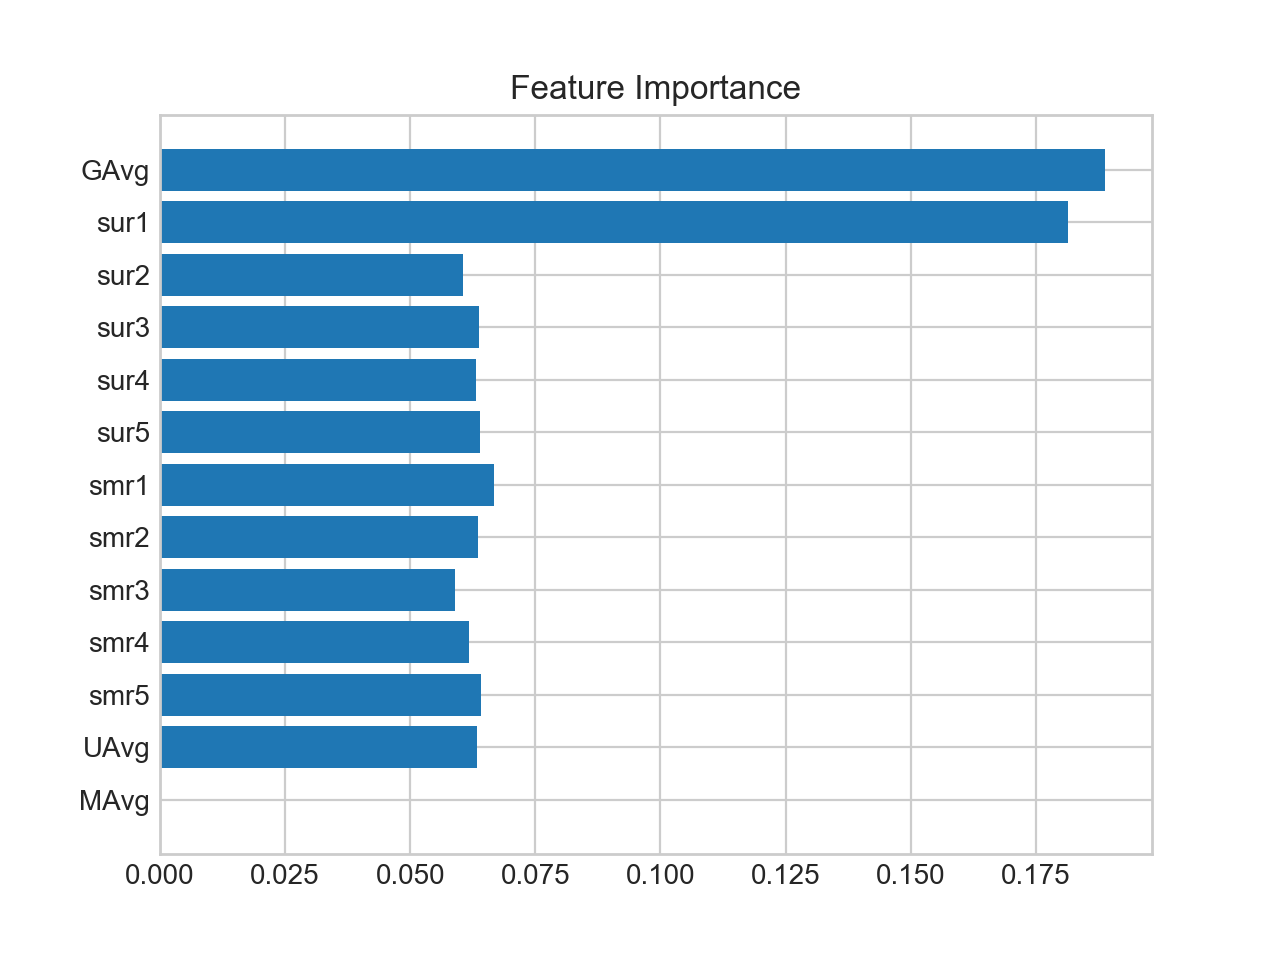

In [83]:
plt.barh(index,model_feat)
plt.yticks(index[::-1],reg_train.columns.drop(['user','movie','rating']).values)
plt.title('Feature Importance')
plt.show()

In [84]:
print('RMSE of the model ',models_evaluation_test['first_algo']['rmse'])
print('MAPE of the model ',models_evaluation_test['first_algo']['mape'])

RMSE of the model  1.0976753897724045
MAPE of the model  33.680610122809995


In [85]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Suprise BaselineModel

In [86]:
from surprise import BaselineOnly 

#### Predicted_rating : ( baseline prediction )


 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 


### Optimization function ( Least Squares Problem )

> $ \small \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [87]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)

# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:06.063532 

Evaluating the model with train data..
time taken : 0:00:07.331574
---------------
Train Data
---------------
RMSE : 0.9222701857120528

MAPE : 28.67125825450987

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.965163
---------------
Test Data
---------------
RMSE : 1.0807692401747715

MAPE : 34.12066770185006

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:15.360996


### XGBoost with initial 13 features + Surprise Baseline predictor

#### Updating Train data

In [88]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.683885
1,2234845,2462,3.587581,4.0,3.0,5.0,2.0,5.0,4.0,3.0,4.0,3.0,3.0,3.391892,3.706219,3,3.635137


#### Updating Test data

In [89]:
reg_test['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1129620,2,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581
1,2138793,2001,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581


In [93]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results,model = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test,param_tuning=True)
# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

In [91]:
model_bsl_feat = model.best_estimator_.feature_importances_
index = np.arange(len(model_bsl_feat))

<IPython.core.display.Javascript object>


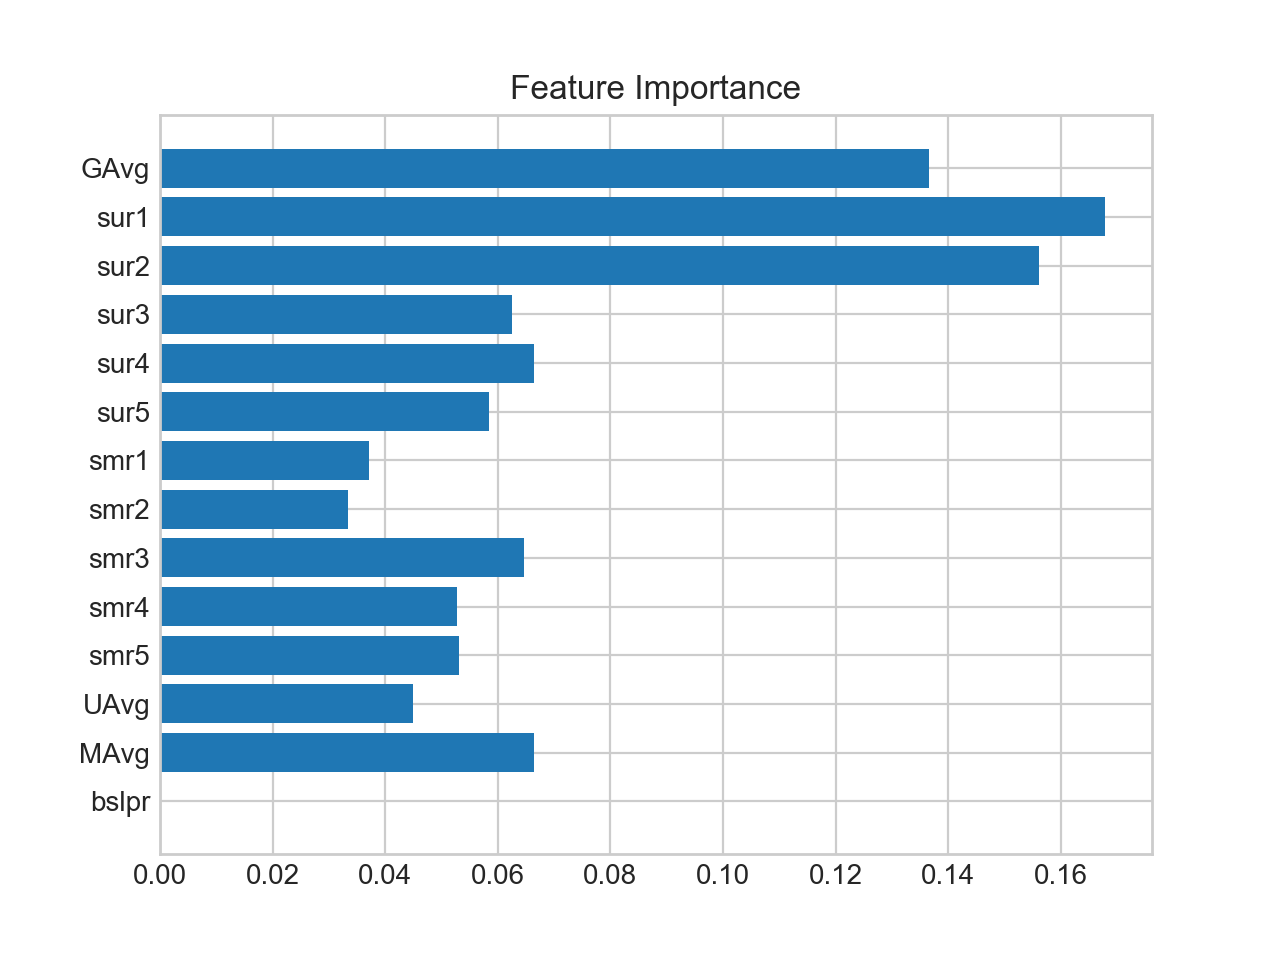

In [92]:
plt.barh(index,model_bsl_feat)
plt.yticks(index[::-1],reg_train.columns.drop(['user','movie','rating']).values)
plt.title('Feature Importance')
plt.show()

In [95]:
print('RMSE of the model ',models_evaluation_test['first_algo']['rmse'])
print('MAPE of the model ',models_evaluation_test['first_algo']['mape'])

RMSE of the model  1.0976753897724045
MAPE of the model  33.680610122809995


In [96]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=13, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

### Surprise KNNBaseline predictor

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
    
    
 - __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

 -  ___Notations follows same as above (user user based predicted rating ) ___

In [97]:
from surprise import KNNBaseline

### Surprise KNNBaseline with user user similarities

In [100]:
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:09:18.044739 

Evaluating the model with train data..
time taken : 0:32:41.125006
---------------
Train Data
---------------
RMSE : 0.4553212654215908

MAPE : 12.87848256912153

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:03.633621
---------------
Test Data
---------------
RMSE : 1.0809905833652425

MAPE : 34.11937522257523

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:42:02.810911


### Surprise KNNBaseline with movie movie similarities

In [98]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:13.964878 

Evaluating the model with train data..
time taken : 0:02:10.684264
---------------
Train Data
---------------
RMSE : 0.5070573742668101

MAPE : 14.244816149750783

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.844345
---------------
Test Data
---------------
RMSE : 1.0812378278062031

MAPE : 34.12285606172596

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:26.494165


### XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

First we will run XGBoost with predictions from both KNN's ( that uses User_User and Item_Item similarities along with our previous features.

Then we will run XGBoost with just predictions form both knn models and predictions from our baseline model.

#### Preparing train data

In [101]:
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.683885,4.981144,4.890272
1,2234845,2462,3.587581,4.0,3.0,5.0,2.0,5.0,4.0,3.0,4.0,3.0,3.0,3.391892,3.706219,3,3.635137,3.000000,3.039151


#### Preparing test data

In [102]:
reg_test['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1129620,2,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581,3.587581,3.587581
1,2138793,2001,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581,3.587581,3.587581


In [108]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

# initialize Our first XGBoost model...
xgb_knn_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results,model = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test,param_tuning=True)
# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

In [104]:
model_knn_bsl_feat = model.best_estimator_.feature_importances_
index = np.arange(len(model_knn_bsl_feat))

<IPython.core.display.Javascript object>


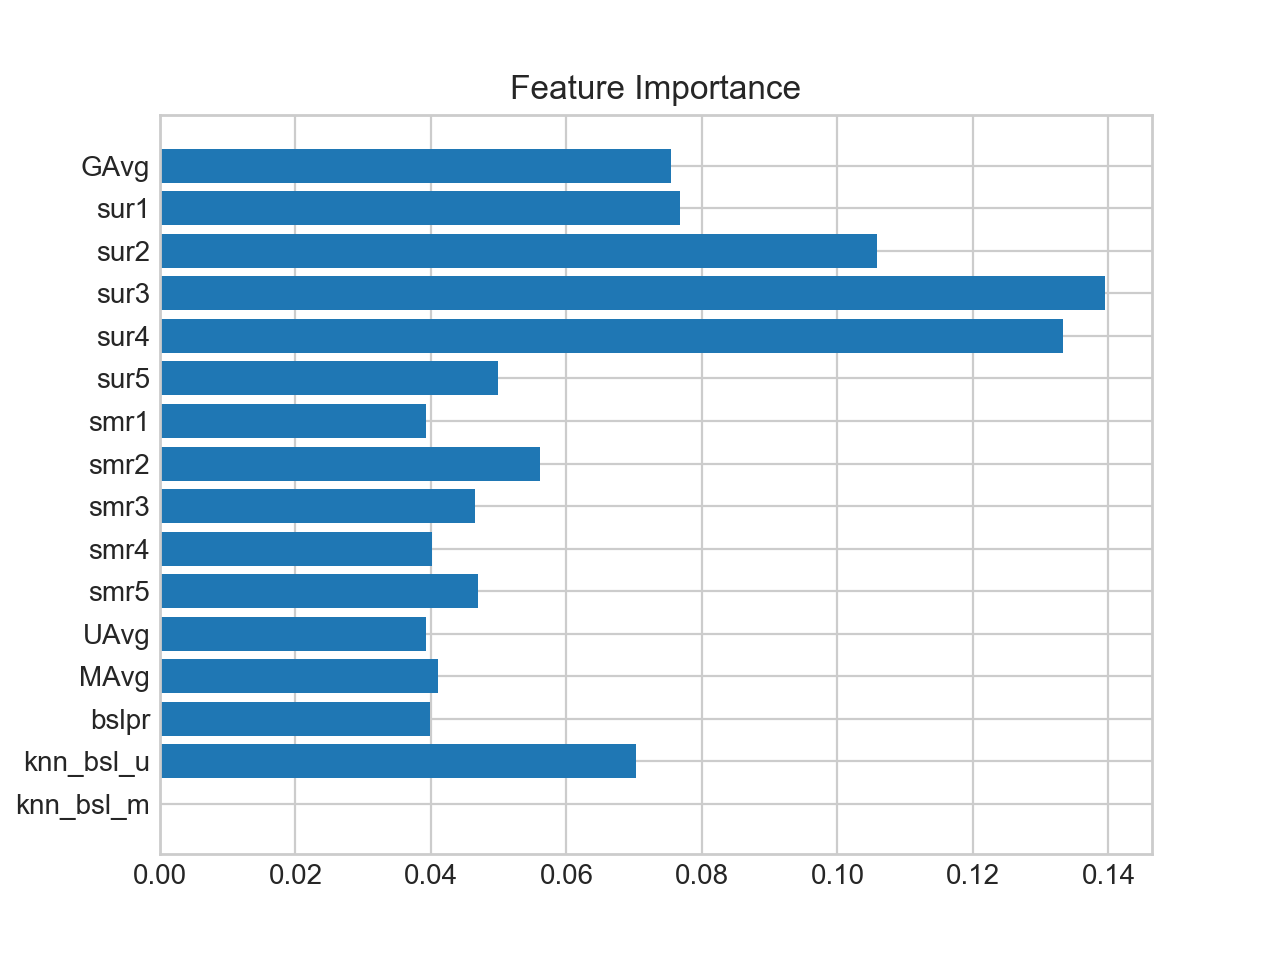

In [105]:
plt.barh(index,model_knn_bsl_feat)
plt.yticks(index[::-1],reg_train.columns.drop(['user','movie','rating']).values)
plt.title('Feature Importance')
plt.show()

In [106]:
print('RMSE of the model ',models_evaluation_test['first_algo']['rmse'])
print('MAPE of the model ',models_evaluation_test['first_algo']['mape'])

RMSE of the model  1.0976753897724045
MAPE of the model  33.680610122809995


In [107]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=13, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

### Matrix Factorization Techniques

#### SVD Matrix Factorization User Movie intractions

In [109]:
from surprise import SVD

- __ Predicted Rating : __
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        

#### Optimization problem with user item interactions and regularization (to avoid overfitting)
 
-  
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [110]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:56.486573 

Evaluating the model with train data..
time taken : 0:00:09.890731
---------------
Train Data
---------------
RMSE : 0.6726754080974513

MAPE : 20.00865971661618

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.743347
---------------
Test Data
---------------
RMSE : 1.0808431225891215

MAPE : 34.06260816089279

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:08.121346


#### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

In [111]:
from surprise import SVDpp

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 
    
- $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [112]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:42:14.991338 

Evaluating the model with train data..
time taken : 0:01:48.937789
---------------
Train Data
---------------
RMSE : 0.6641641097393512

MAPE : 19.392994085492056

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:02.131617
---------------
Test Data
---------------
RMSE : 1.081230689447865

MAPE : 34.03604658994542

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:44:06.061456


### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

#### Preparing Train data

In [113]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.683885,4.981144,4.890272,4.155717,3.914327
1,2234845,2462,3.587581,4.0,3.0,5.0,2.0,5.0,4.0,3.0,...,3.0,3.0,3.391892,3.706219,3,3.635137,3.000000,3.039151,3.597654,3.383105


#### Preparing Test data

In [114]:
reg_test['svd'] = models_evaluation_test['svd']['predictions']
reg_test['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1129620,2,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,...,3.587581,3.587581,3.587581,3.587581,3,3.587581,3.587581,3.587581,3.587581,3.587581
1,2138793,2001,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,...,3.587581,3.587581,3.587581,3.587581,3,3.587581,3.587581,3.587581,3.587581,3.587581


In [137]:
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

x_test = reg_test.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test['rating']

xgb_final = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15, n_estimators=100)
train_results, test_results,model = run_xgboost(xgb_final, x_train, y_train, x_test, y_test,param_tuning=True)
# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

In [116]:
model_final = model.best_estimator_.feature_importances_
index = np.arange(len(model_final))

<IPython.core.display.Javascript object>


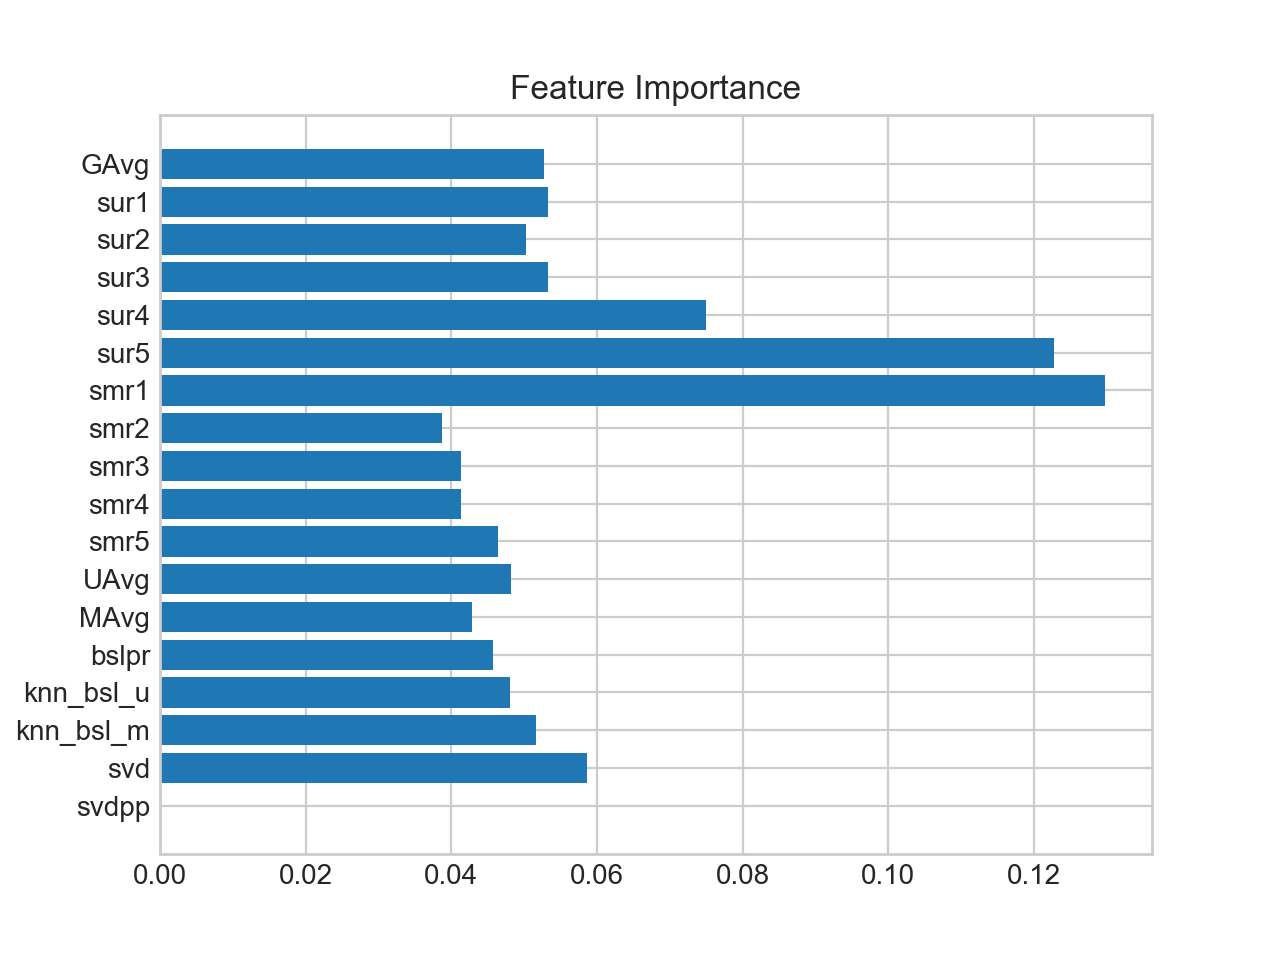

In [117]:
plt.barh(index,model_final)
plt.yticks(index[::-1],reg_train.columns.drop(['user','movie','rating']).values)
plt.title('Feature Importance')
plt.show()

In [118]:
print('RMSE of the model ',models_evaluation_test['first_algo']['rmse'])
print('MAPE of the model ',models_evaluation_test['first_algo']['mape'])

RMSE of the model  1.0976753897724045
MAPE of the model  33.680610122809995


In [119]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

#### Preparing train data

In [136]:
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test['rating']

xgb_all_models = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15, n_estimators=100)
train_results, test_results,model = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test,param_tuning=True)
# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

In [125]:
model_final_all = model.best_estimator_.feature_importances_
index = np.arange(len(model_final_all))

<IPython.core.display.Javascript object>


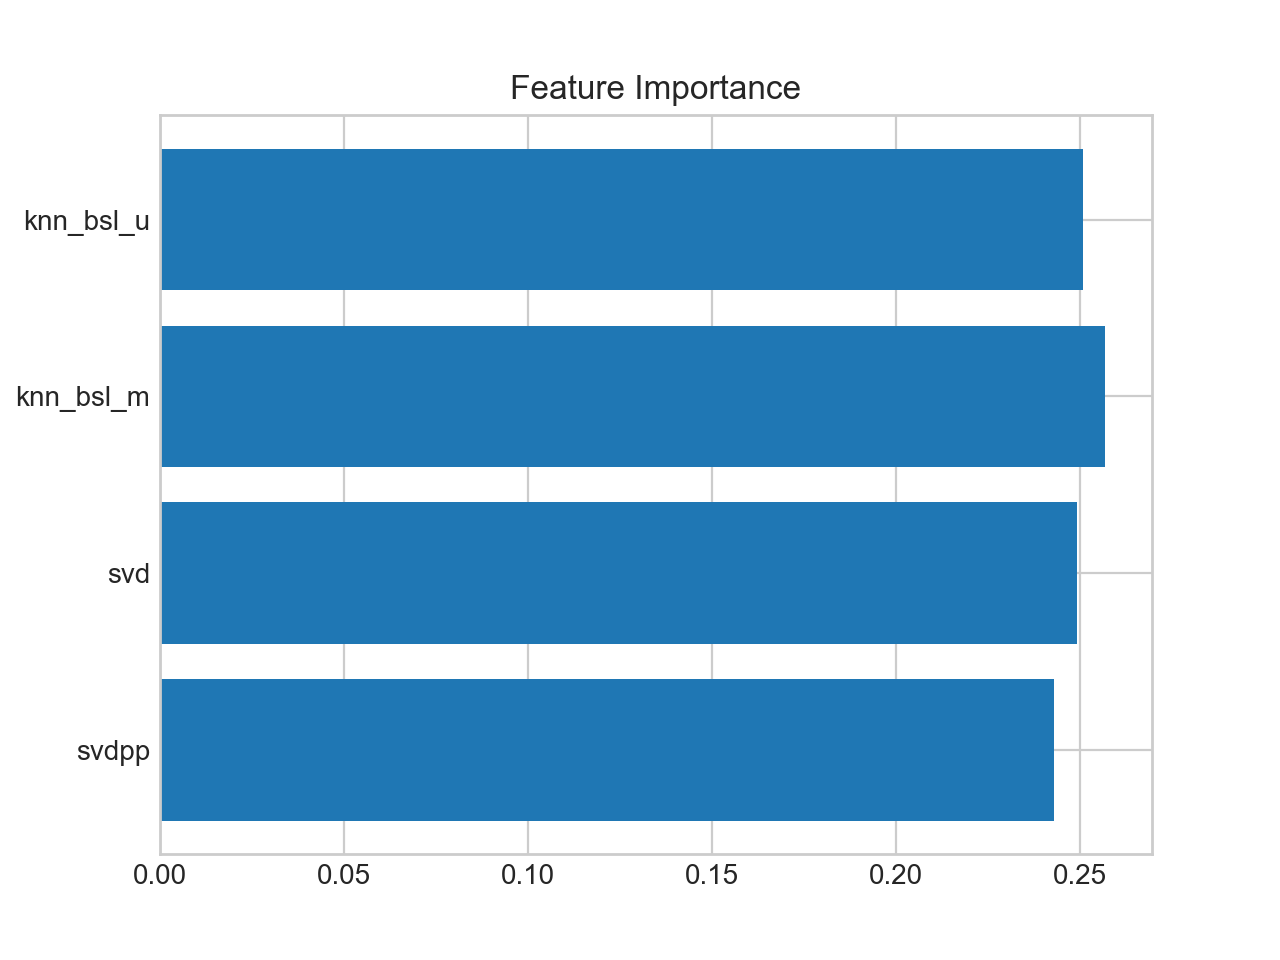

In [132]:
plt.barh(index,model_final_all)
plt.yticks(index[::-1],reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']].columns.values)
plt.title('Feature Importance')
plt.show()

In [133]:
print('RMSE of the model ',models_evaluation_test['first_algo']['rmse'])
print('MAPE of the model ',models_evaluation_test['first_algo']['mape'])

RMSE of the model  1.0976753897724045
MAPE of the model  33.680610122809995


In [134]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

### Comparision between all models

In [135]:
pd.DataFrame(models_evaluation_test).to_csv('sample/small/small_sample_results.csv')
models = pd.read_csv('sample/small/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

bsl_algo          1.0807692401747715
svd               1.0808431225891215
knn_bsl_u         1.0809905833652425
svdpp              1.081230689447865
knn_bsl_m         1.0812378278062031
xgb_all_models    1.0892050443245518
first_algo        1.0976753897724045
xgb_knn_bsl       1.1004950867993388
xgb_bsl           1.1240616288758492
xgb_final         1.1389637594801547
Name: rmse, dtype: object

### Overview of all steps

1. Merging all text files into a single csv file of the format Users(u_i),Movies(m_j) and Ratings(r_ij).

2. Sorting the dataframe by date column and removing any duplicate values if present.

3. Splitting into train and test data and performing Exploratory Data Analysis on it. The various steps are shown below:

    3.1 Finding no.of users, ratings and movies in train and test data    
    3.2 Distribution of ratings (0-5), Ratings per month, Max no. of ratings given by each user, quantiles of the ratings given, max no. of ratings given for a movie across all users etc.
    
4. Creating sparse matrix from train and test data and analysing the sparsity.

5. Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

6. Analysing the cold start problem in Users and Movies (No. of users or movies that didn't appear in train data.)

7. Compute User-User Similarity matrix and Movie-Movie similarity matrix.

8. Getting sample sparse matrices from train and test data.

9. Featurizing the data by selecting the top 5 ratings given by similar users to a particular user and also top 5 ratings given to similar movies with respect to particular movie.

10. Run XGBoost on the 13 features that are obtained.

11. Run Surprise Baseline only model on train and test data and combine the train and test results with the 13 features and run XGBoost again on top of it.

12. Run Surprise KNNBaseline only model on train and test data and combine the train and test results with the 13 features,Baseline only model features and run XGBoost again on top of it.

13. Run Surprise SVD and SVD++ matrix factorization models on train and test data and combine the train and test results with the 13 features,Baseline only model, KNN Baseline model features and run XGBoost again on top of it.

14. Hyperparameter tune the above XGBoost models using GridSearch CV and plot the feature importance of each model.

15. Comparing all the models that are obtained.